In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# **Import Required Libraries And Framework**

In [2]:
# Importing necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
import warnings

# Ignore warnings for clean output
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


# **Load the Data**

In [3]:
# Load data with error handling
train_path = "/kaggle/input/System-Threat-Forecaster/train.csv"
test_path = "/kaggle/input/System-Threat-Forecaster/test.csv"

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset not found. Please check the file path.")
    exit()


Data loaded successfully!


# **Exploratory Data Analysis(EDA)**

In [4]:
#Quick Look At Train Data
train_df.head()

MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0            53447.0                            1.0   
1                     0            53447.0                            1.0   
2                     0            53447.0                            1.0   
3                     0            46413.0                            2.0   
4                     0            40466.0                            2.0   

   ...  IsSecureBootEnabled  IsVirtualDevice  IsTouchEnabled  IsPenCapable  \
0  ...                    0              0.0               1             0   
1  ...                    1              0.0               0             0   
2  ...                    0              0.0               0             0   
3  ...                    1              0.0               0             0   
4  ...                    0              0.0               0             0   

   IsAlwaysOnAlwaysConnectedCapable  IsGamer RegionIdentifier  \
0                               1.0      0.0              6.0   
1                               0.0      0.0             10.0   
2                               0.0      1.0              6.0   
3                               0.0      0.0             12.0   
4                               0.0      1.0              7.0   

                DateAS      DateOS  target  
0  2018-09-10 10:11:00  2018-04-17       0  
1  2018-08-16 00:01:00  2018-08-14       1  
2  2018-09-20 23:20:00  2018-09-11       1  
3  2018-09-14 00:32:00  2018-01-03       1  
4  2018-09-15 19:34:00  2018-09-11       0  

[5 rows x 76 columns]

In [5]:
# Display dataset info
print("\nTraining data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

print("\nFirst few rows of train dataset:\n", train_df.head())

# Check for missing values
print("\nMissing values in train data:\n", train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nMissing values in test data:\n", test_df.isnull().sum()[test_df.isnull().sum() > 0])



Training data shape: (100000, 76)
Testing data shape: (10000, 75)

First few rows of train dataset:
                           MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  Antivir

In [6]:
#Quick Look At Test Data
test_df.head()

MachineID   ProductName EngineVersion  \
0  c2c61173092ad20db5585ca8c10de6e0  win8defender   1.1.15100.1   
1  2e6bb5362ba1ce897feeb1de5edea686  win8defender   1.1.15100.1   
2  692649baed1c50bb8d051ae7f06e3625  win8defender   1.1.15200.1   
3  2ff95e7d97e9f80ec81c97622dd93ed6  win8defender   1.1.15300.6   
4  256766b4c5011e146f05b323863e08a4  win8defender   1.1.14800.3   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.273.1276.0           0                      7.0   
1        4.10.209.0      1.273.371.0           0                      7.0   
2   4.18.1807.18075      1.275.263.0           0                      7.0   
3   4.18.1807.18075       1.277.58.0           0                      7.0   
4  4.14.17639.18041      1.267.898.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0            53447.0                            1.0   
1                     0            46184.0                            2.0   
2                     0            51954.0                            2.0   
3                     0            41571.0                            2.0   
4                     0            40645.0                            3.0   

   ...  FirmwareVersionID  IsSecureBootEnabled  IsVirtualDevice  \
0  ...            48751.0                    0              0.0   
1  ...            64709.0                    1              0.0   
2  ...            33094.0                    1              0.0   
3  ...            26184.0                    1              0.0   
4  ...            12126.0                    0              0.0   

   IsTouchEnabled  IsPenCapable  IsAlwaysOnAlwaysConnectedCapable IsGamer  \
0               0             0                               0.0     1.0   
1               0             0                               0.0     0.0   
2               0             0                               0.0     0.0   
3               0             0                               0.0     0.0   
4               0             0                               0.0     0.0   

  RegionIdentifier               DateAS      DateOS  
0             11.0  2018-08-12 13:12:00  2018-07-10  
1             12.0  2018-07-26 06:54:00  2016-10-11  
2             10.0  2018-08-27 17:29:00  2018-05-08  
3             10.0  2018-09-25 22:13:00  2018-05-08  
4              7.0  2018-05-06 01:31:00  2018-06-12  

[5 rows x 75 columns]

Only  difference in train and test data is the presence of **target** in train dataset only,which is a usual behaviour .

In [7]:
#Get Basic Info About Training Data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

There Are Different Datatypes and 31 columns have nulls (e.g., RealTimeProtectionState, SMode, IEVersionID, FirmwareManufacturerID)

In [8]:
#Get Basic Statistical Analysis Detail On Training Data
train_df.describe()

IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000                       1.000000   
75%         53447.000000                       2.000000   
max         70490.000000                       5.000000   

       NumAntivirusProductsEnabled         HasTpm      CountryID  \
count                 99924.000000  100000.000000  100000.000000   
mean                      1.018264       0.996780     108.078790   
std                       0.155291       0.056654      63.062151   
min                       0.000000       0.000000       1.000000   
25%                       1.000000       1.000000      51.000000   
50%                       1.000000       1.000000      97.000000   
75%                       1.000000       1.000000     162.000000   
max                       4.000000       1.000000     222.000000   

              CityID    GeoRegionID  ...  FirmwareManufacturerID  \
count   99377.000000  100000.000000  ...            99624.000000   
mean    81029.938587     169.741630  ...              401.987613   
std     48944.027074      89.188929  ...              221.318891   
min         7.000000       1.000000  ...                2.000000   
25%     36694.000000      89.000000  ...              142.000000   
50%     82373.000000     181.000000  ...              500.000000   
75%    122835.000000     267.000000  ...              556.000000   
max    167957.000000     296.000000  ...             1083.000000   

       FirmwareVersionID  IsSecureBootEnabled  IsVirtualDevice  \
count       99666.000000        100000.000000     99980.000000   
mean        32942.648044             0.495690         0.003841   
std         21151.970827             0.499984         0.061855   
min           121.000000             0.000000         0.000000   
25%         13020.000000             0.000000         0.000000   
50%         33066.000000             0.000000         0.000000   
75%         52357.000000             1.000000         0.000000   
max         72091.000000             1.000000         1.000000   

       IsTouchEnabled   IsPenCapable  IsAlwaysOnAlwaysConnectedCapable  \
count   100000.000000  100000.000000                      99866.000000   
mean         0.128470       0.040580                          0.058398   
std          0.334614       0.197316                          0.234496   
min          0.000000       0.000000                          0.000000   
25%          0.000000       0.000000                          0.000000   
50%          0.000000       0.000000                          0.000000   
75%          0.000000       0.000000                          0.000000   
max          1.000000       1.000000                          1.000000   

            IsGamer  RegionIdentifier         target  
count  99441.000000      99441.000000  100000.000000  
mean       0.296668          7.875866       0.505250  
std        0.456791          4.562533       0.499975  
min        0.000000          1.000000       0.000000  
25%        0.000000          3.000000       0.000000  
50%        0.000000         10.000000       

The dataset contains a wide range of unique machine identifiers (0 to 109,790) and shows a high prevalence of a specific product (mean of 0.9977). Various software versions are present, with engine and app versions averaging 33.96 and 31.56, respectively. Most users have at least one antivirus product installed, while around 30% are identified as gamers, and the target variable indicates a balanced distribution for binary classification (mean of 0.5053).

**Identify the feature types**

In [9]:
# Identify categorical and numerical columns
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ensure 'target' is removed from numerical columns
if 'target' in numerical_columns:
    numerical_columns.remove('target')

print("\nCategorical columns:", categorical_columns)
print("\nNumerical columns:", numerical_columns)


Categorical columns: ['MachineID', 'ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']

Numerical columns: ['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID', 'PrimaryDiskCapacityMB',

Columns with missing values:
SMode                                 0.981
CityID                                0.623
IsGamer                               0.559
RegionIdentifier                      0.559
InternalBatteryNumberOfCharges        0.515
FirmwareManufacturerID                0.376
FirmwareVersionID                     0.334
IsFlightsDisabled                     0.326
OEMModelID                            0.228
OEMNameID                             0.212
FirewallEnabled                       0.166
TotalPhysicalRAMMB                    0.151
IsAlwaysOnAlwaysConnectedCapable      0.134
OSInstallLanguageID                   0.113
SystemVolumeCapacityMB                0.110
PrimaryDiskCapacityMB                 0.110
IEVersionID                           0.107
ProcessorModelID                      0.085
ProcessorManufacturerID               0.085
ProcessorCoreCount                    0.085
AntivirusConfigID                     0.076
IsSystemProtected                     0.076
Num

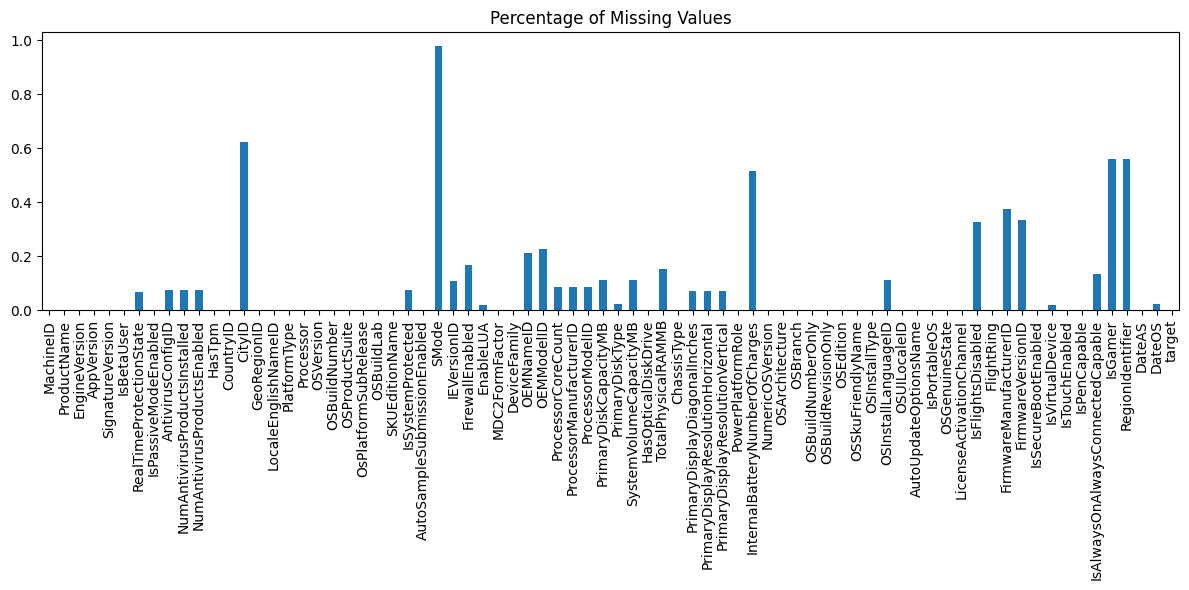

In [10]:
# Identify missing values
missing_percentages = train_df.isnull().mean() * 100
missing_columns = missing_percentages[missing_percentages > 0].sort_values(ascending=False)
print("Columns with missing values:")
print(missing_columns)

# Visualization of missing values
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Percentage of Missing Values')
plt.tight_layout()

**Distribution of Target Variable**

Text(0, 0.5, 'Count')

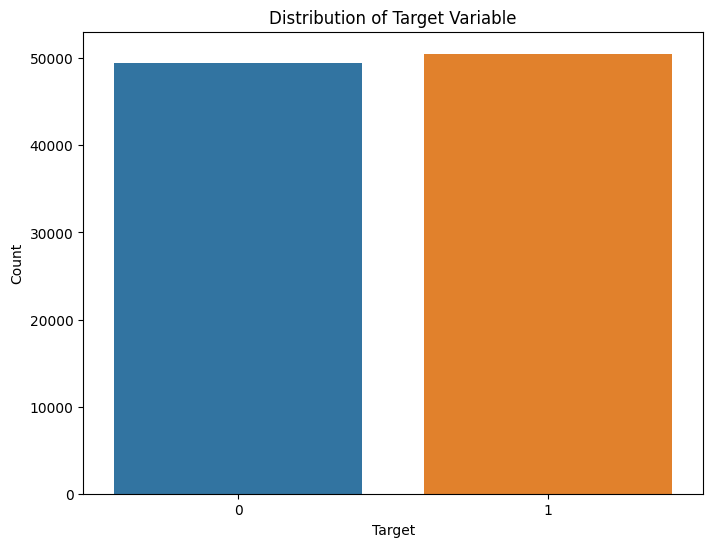

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

Our Dataset train variables seems to be balanced

**Missing Data Heatmap**

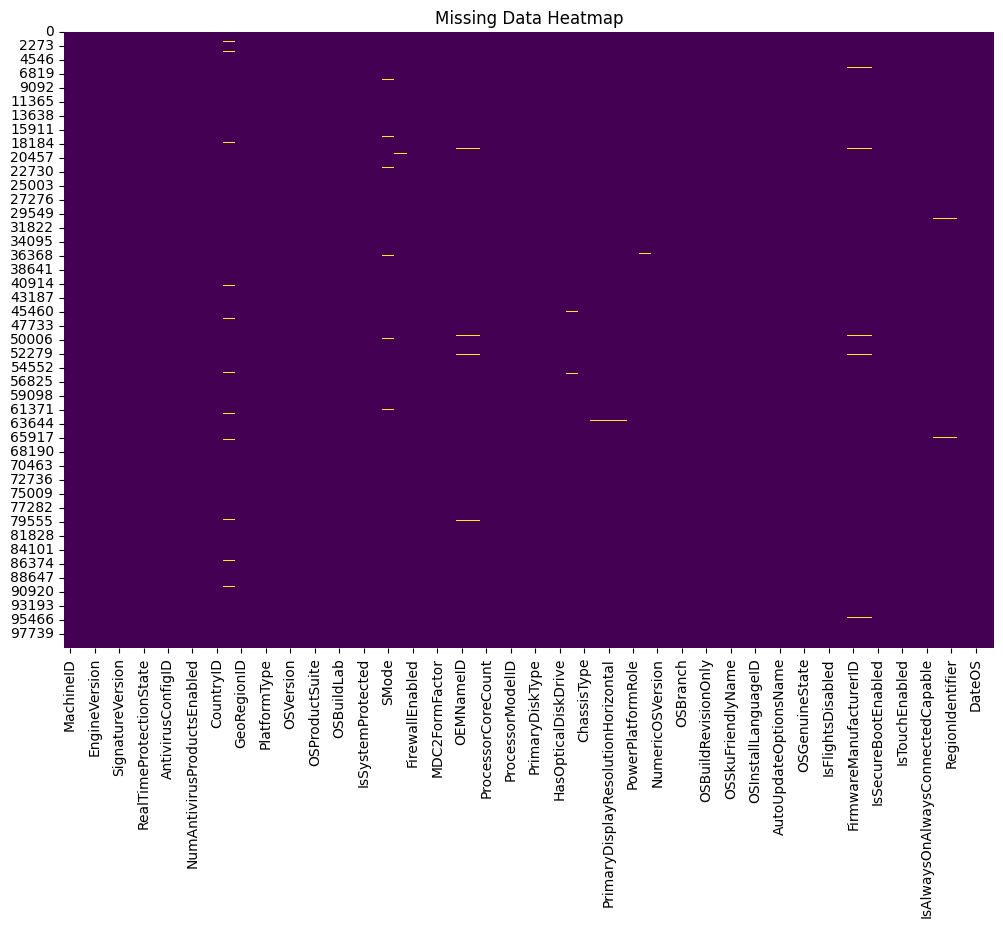

SMode                                 0.981
CityID                                0.623
IsGamer                               0.559
RegionIdentifier                      0.559
InternalBatteryNumberOfCharges        0.515
FirmwareManufacturerID                0.376
FirmwareVersionID                     0.334
IsFlightsDisabled                     0.326
OEMModelID                            0.228
OEMNameID                             0.212
FirewallEnabled                       0.166
TotalPhysicalRAMMB                    0.151
IsAlwaysOnAlwaysConnectedCapable      0.134
OSInstallLanguageID                   0.113
SystemVolumeCapacityMB                0.110
PrimaryDiskCapacityMB                 0.110
IEVersionID                           0.107
ProcessorModelID                      0.085
ProcessorManufacturerID               0.085
ProcessorCoreCount                    0.085
AntivirusConfigID                     0.076
IsSystemProtected                     0.076
NumAntivirusProductsEnabled     

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot missing values heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Show the percentage of missing values per column
missing_data = train_df.isnull().mean() * 100
print(missing_data[missing_data > 0].sort_values(ascending=False))


**Data Distribution & Descriptive Statistics**

       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000         

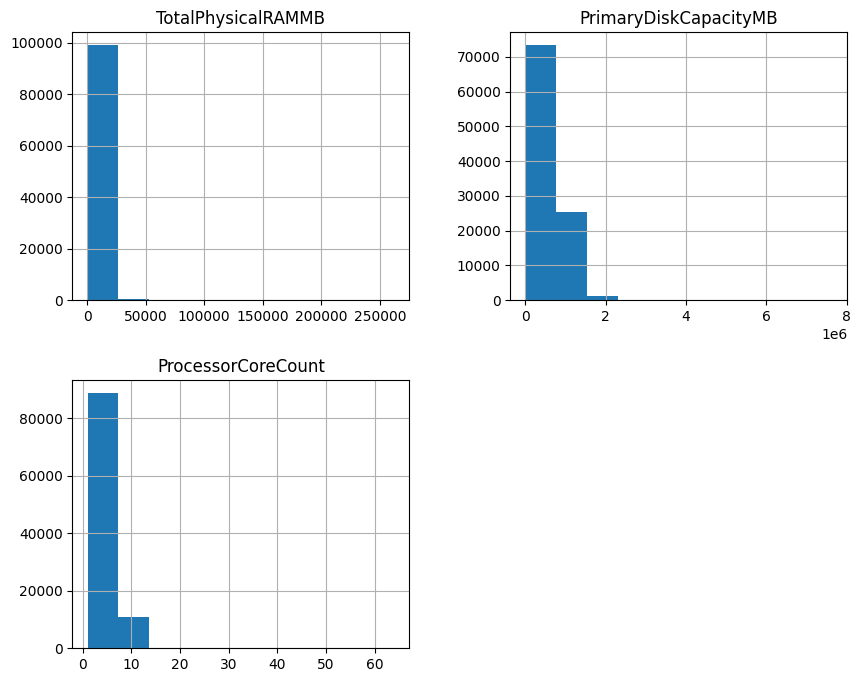

In [13]:
# Display summary statistics for all numeric features
print(train_df.describe())

# Check the distribution of specific features
train_df[['TotalPhysicalRAMMB', 'PrimaryDiskCapacityMB', 'ProcessorCoreCount']].hist(figsize=(10, 8))
plt.show()


**Detailed Visualize distributions of numeric features using histograms**

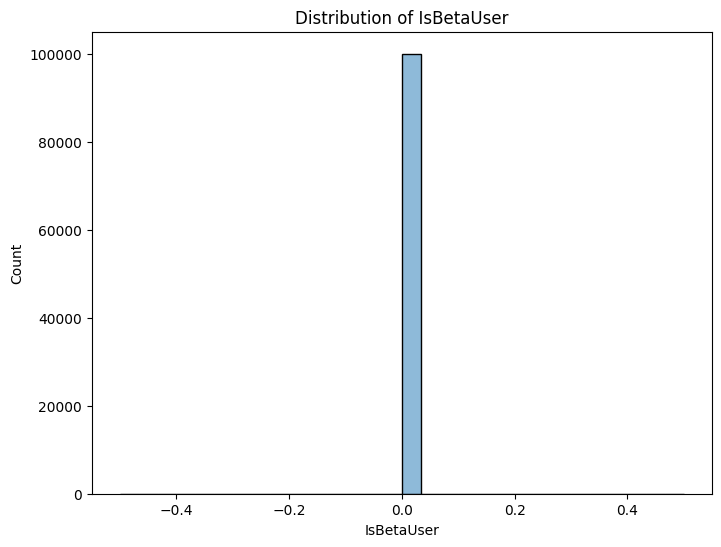

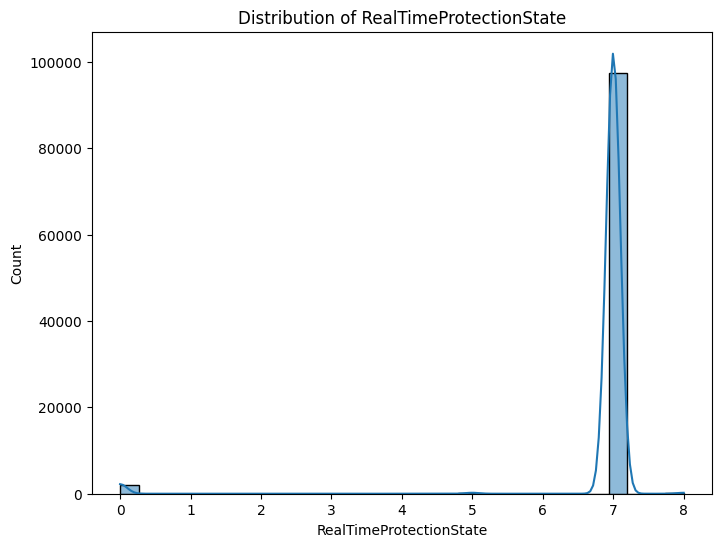

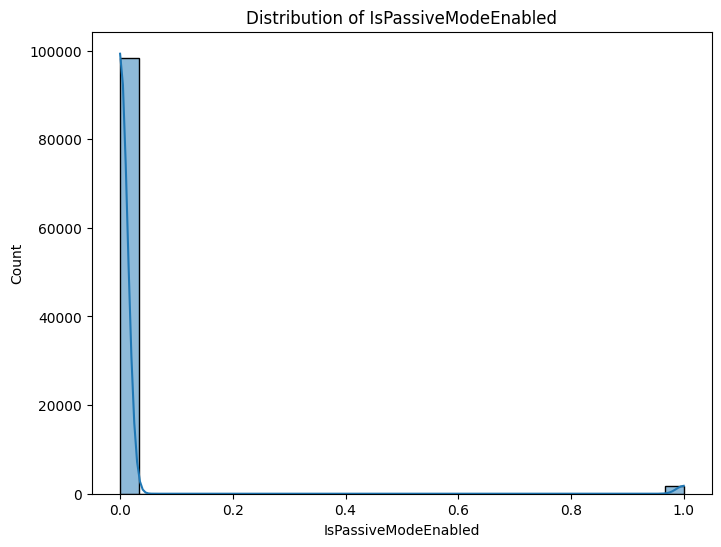

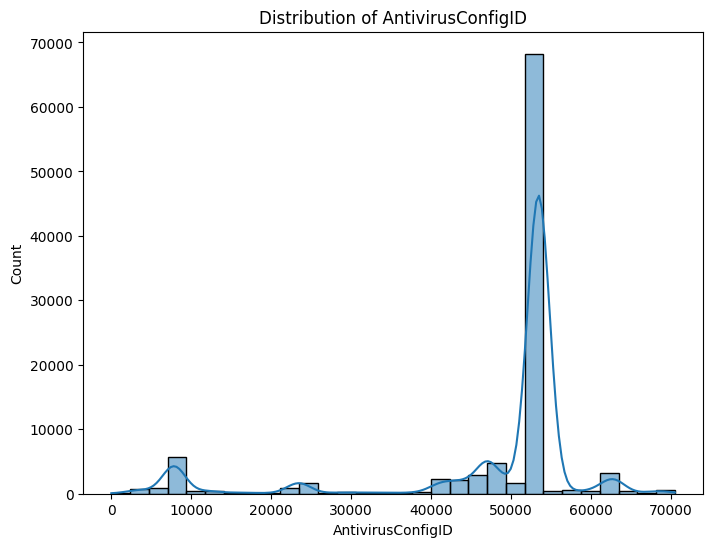

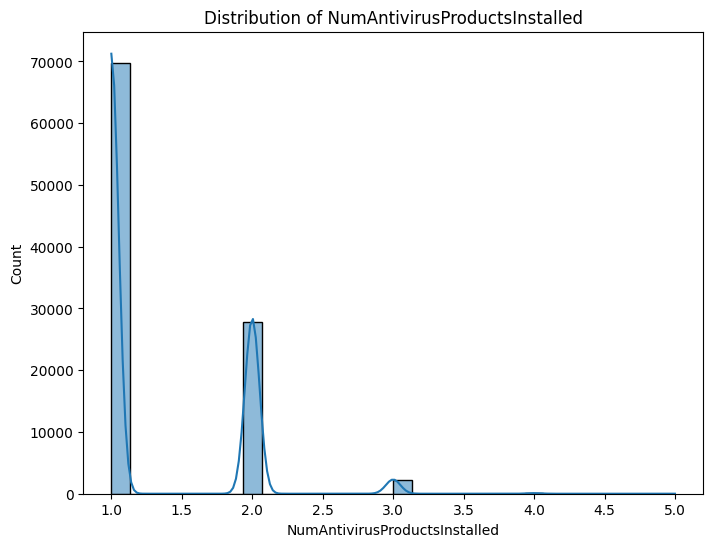

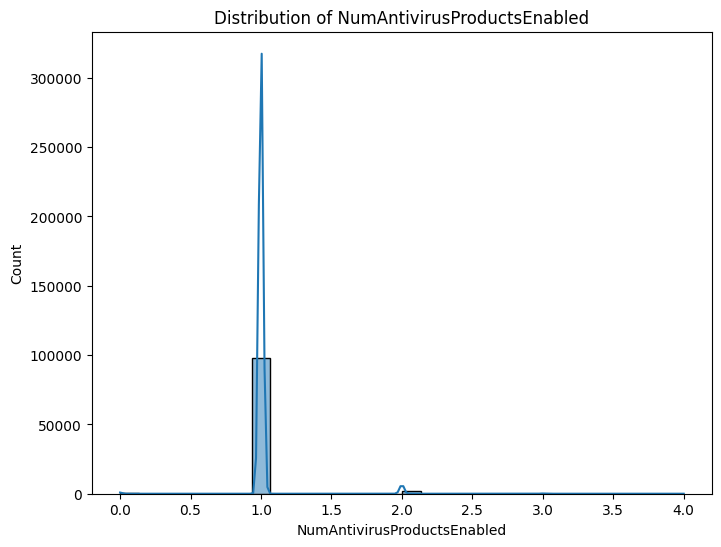

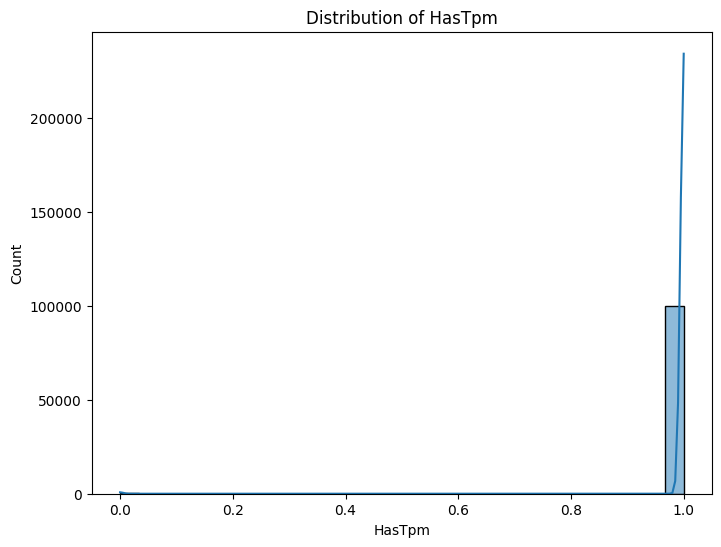

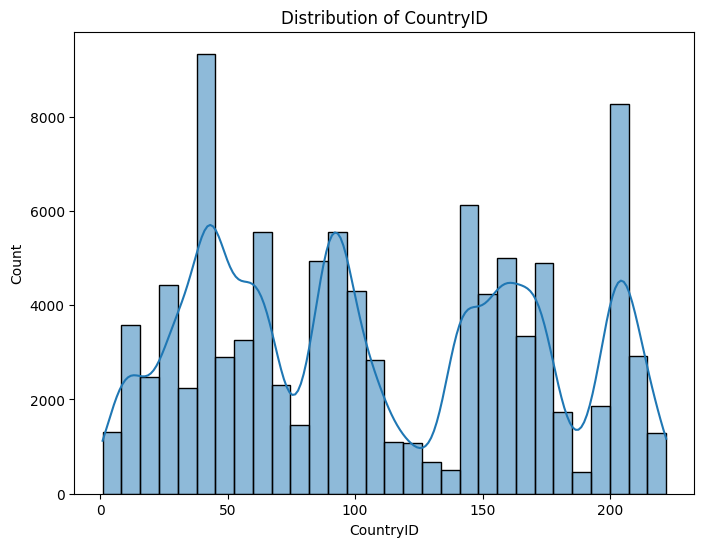

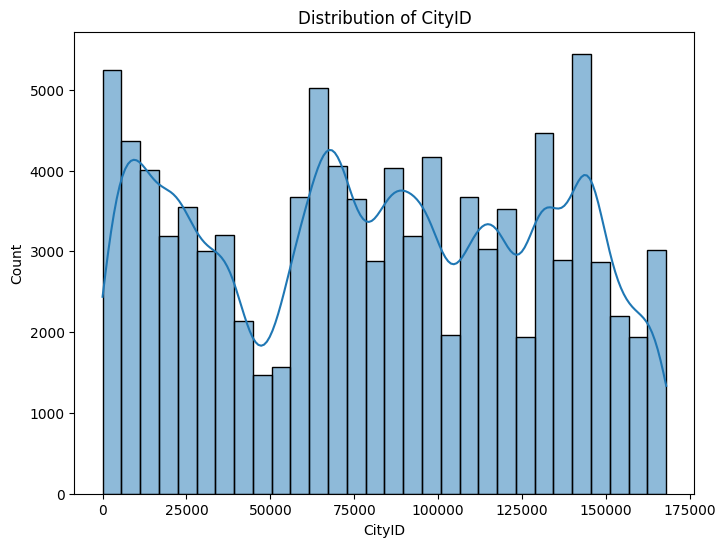

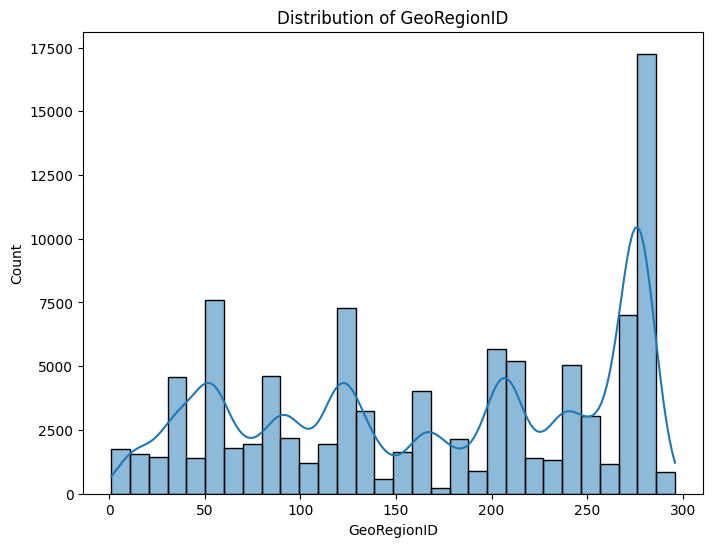

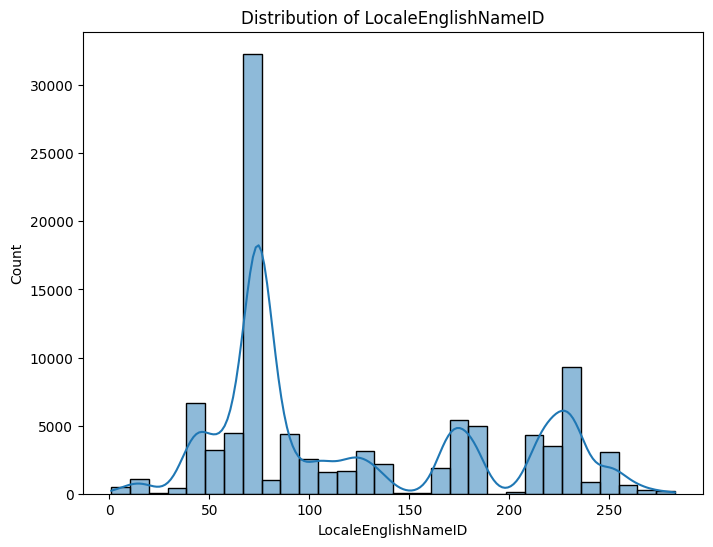

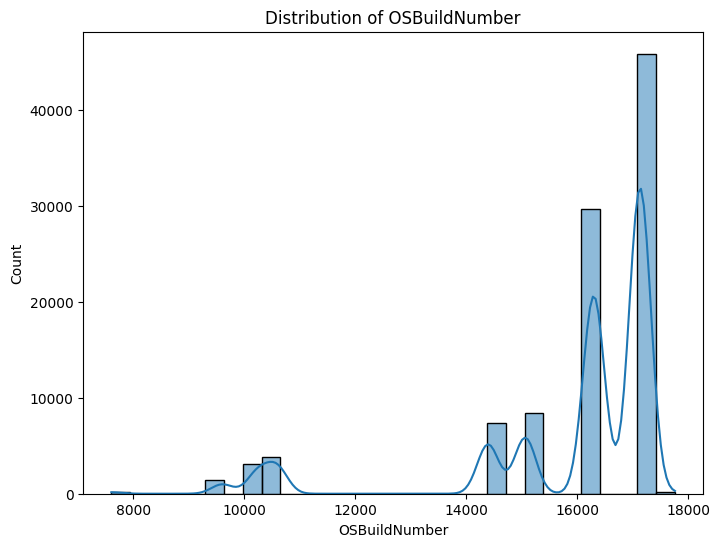

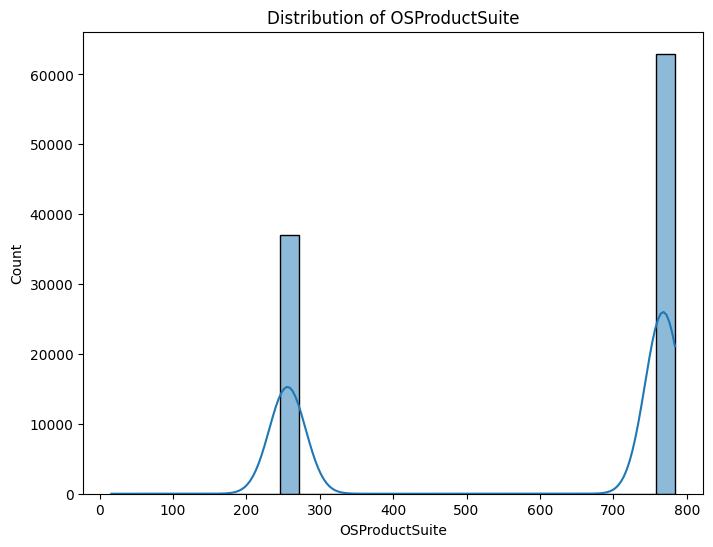

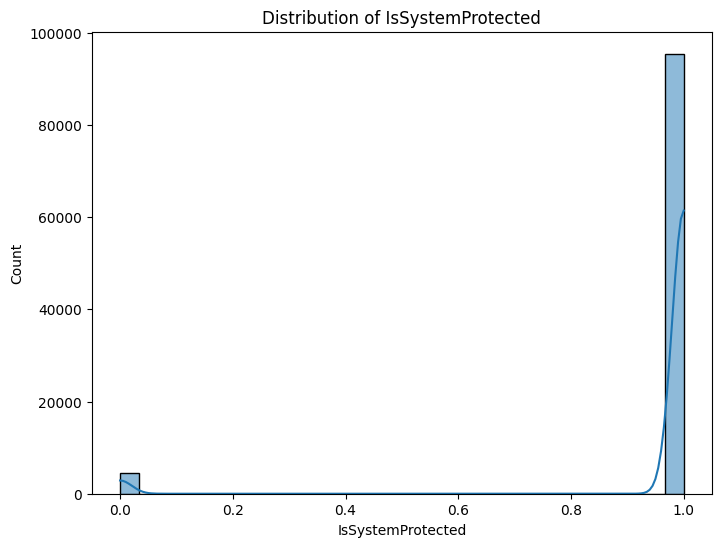

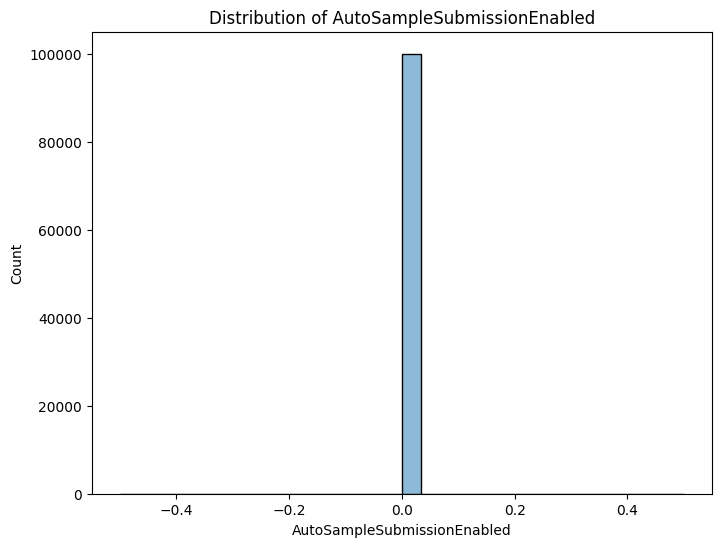

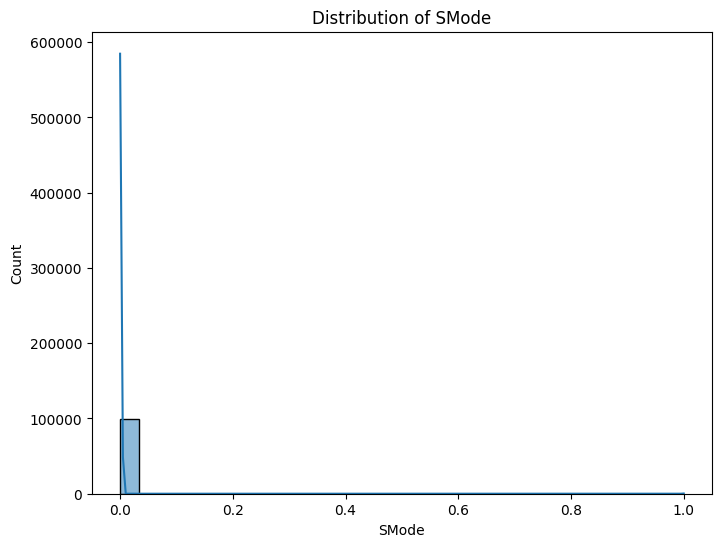

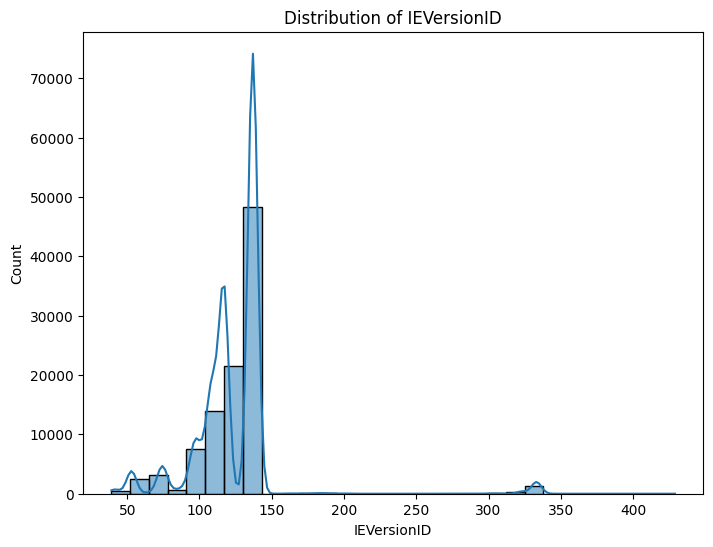

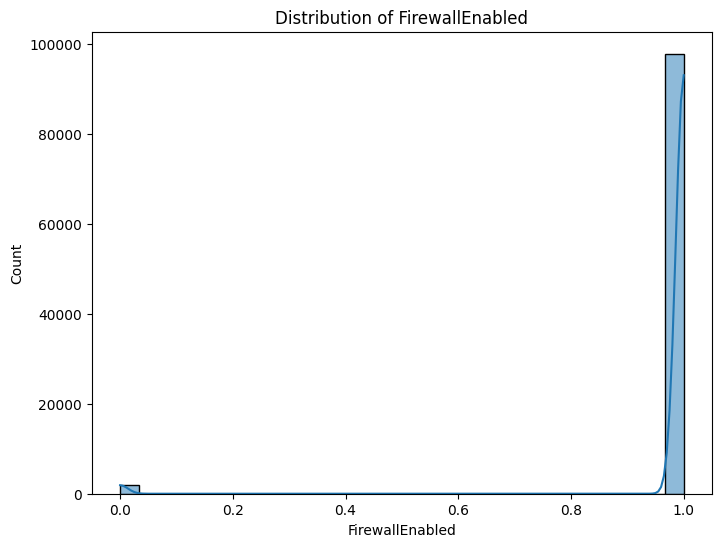

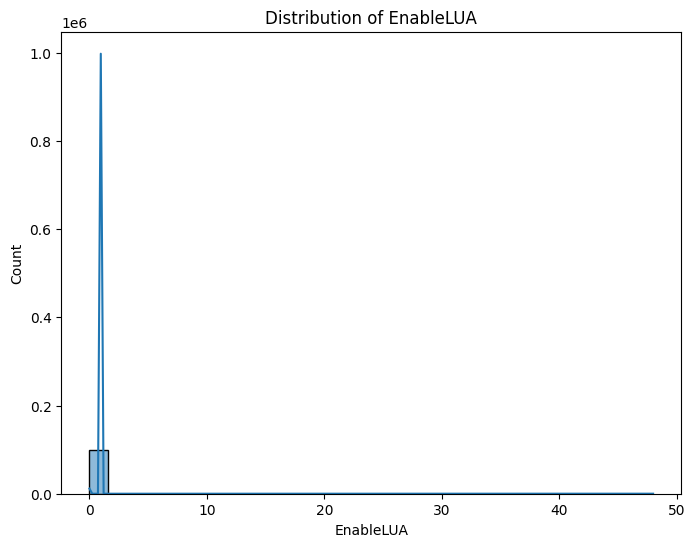

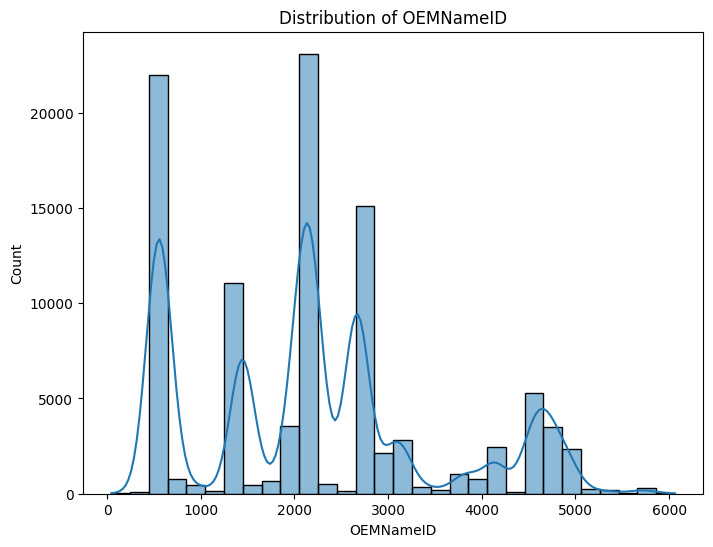

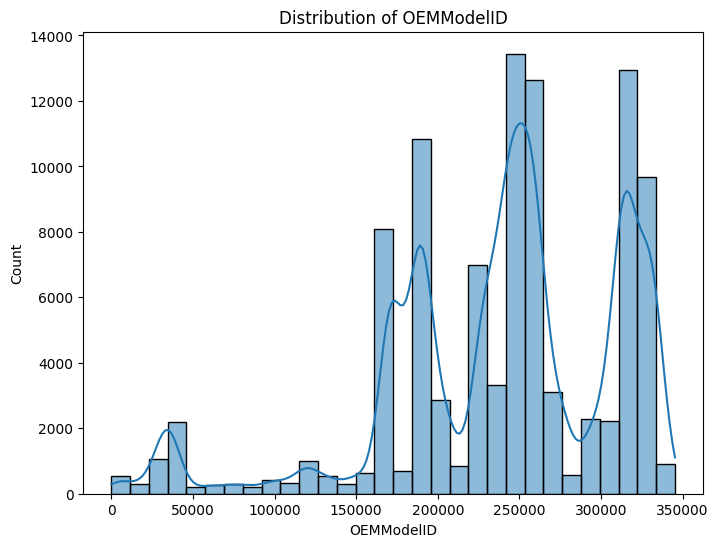

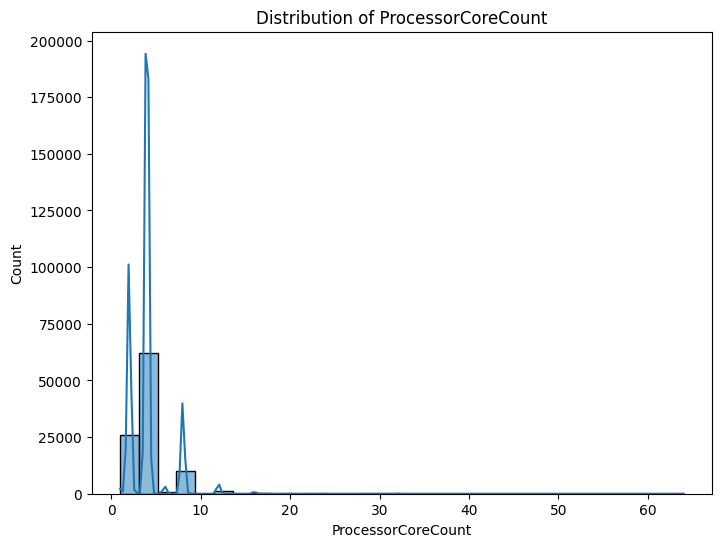

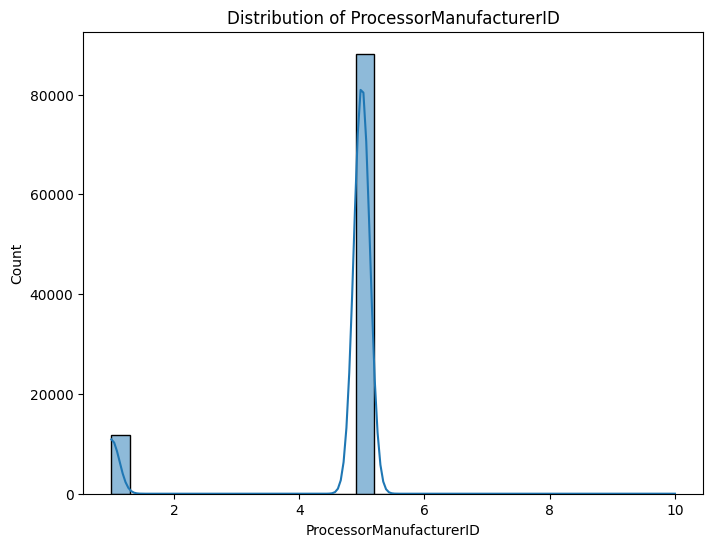

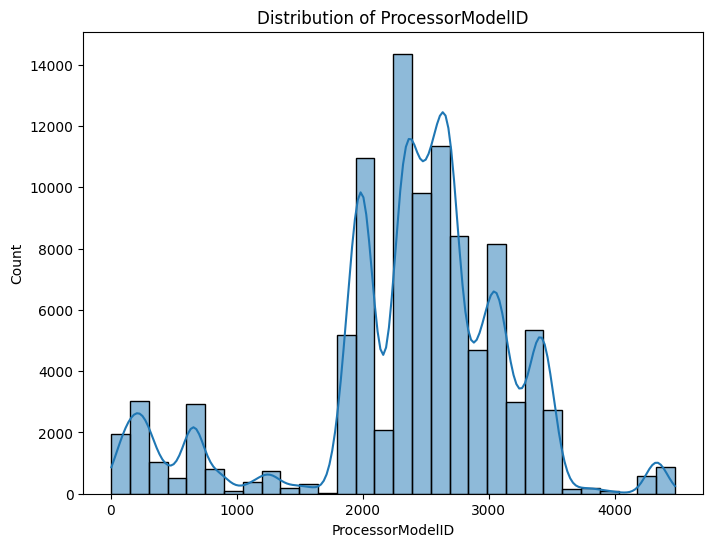

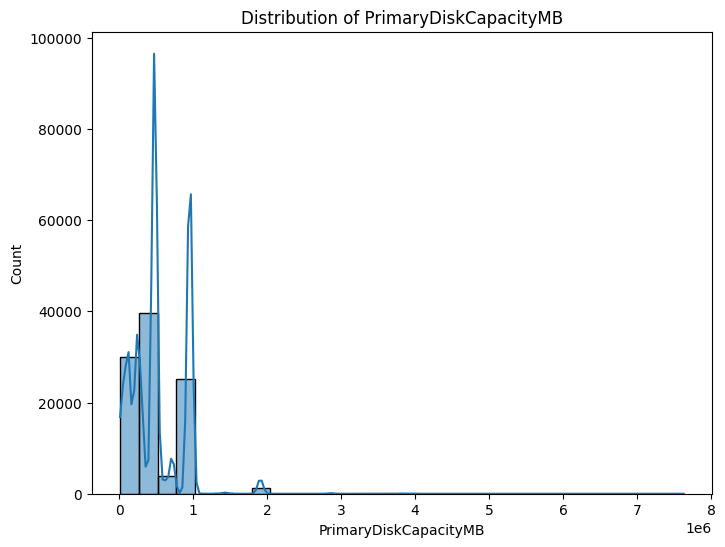

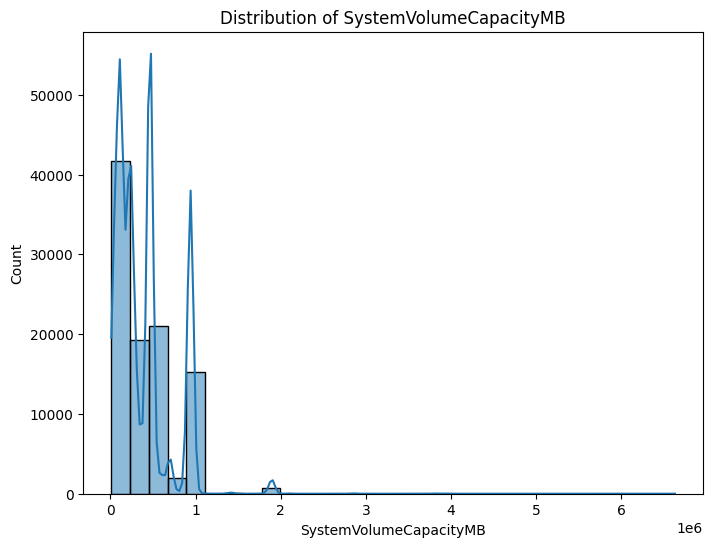

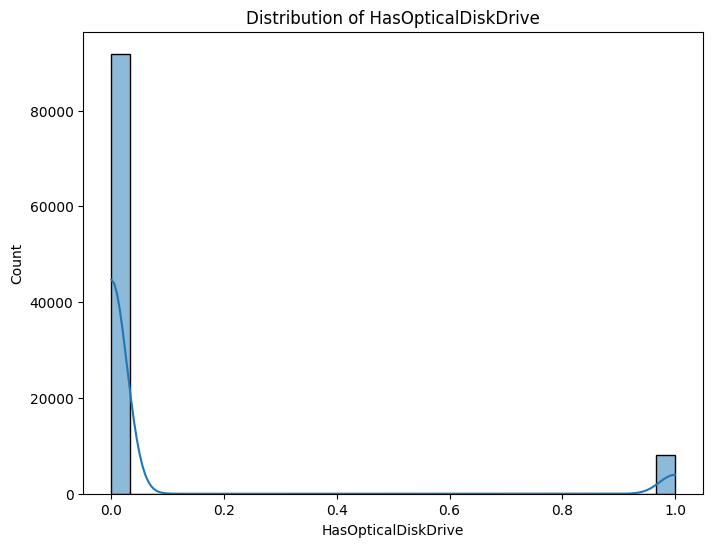

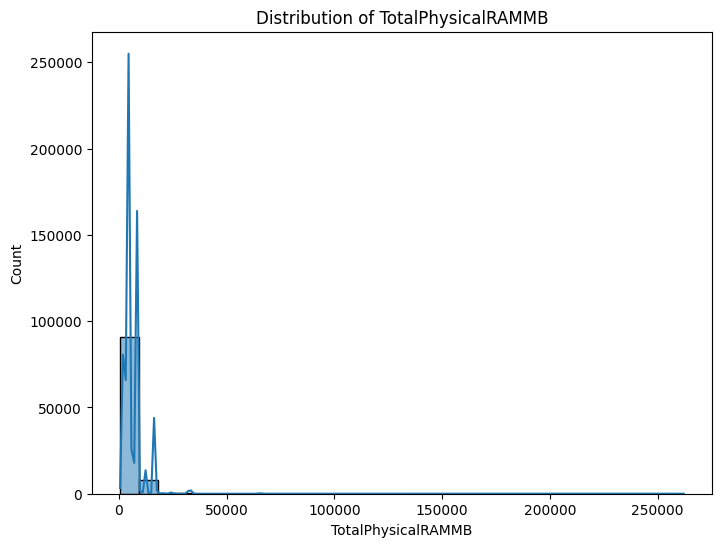

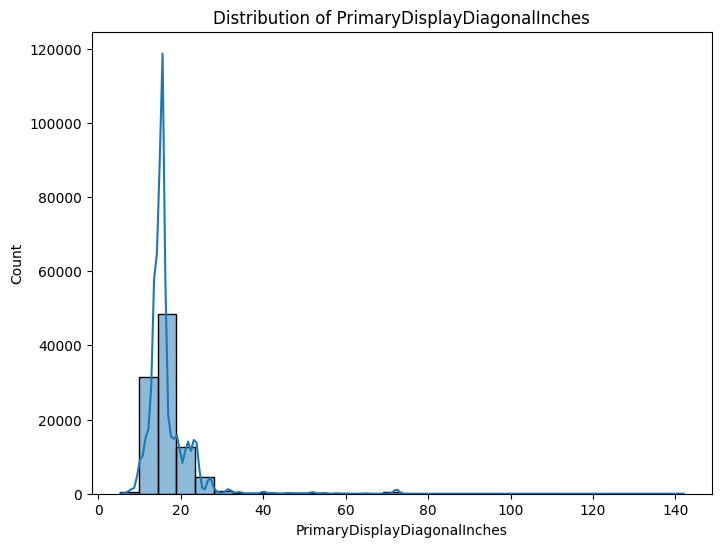

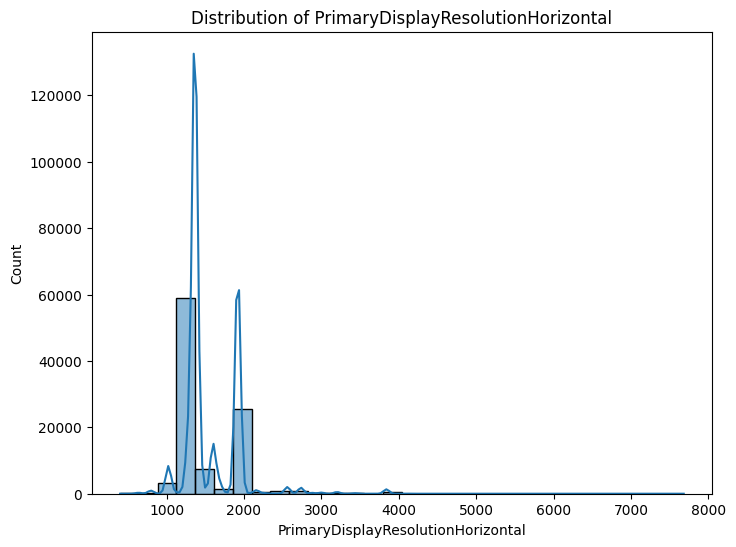

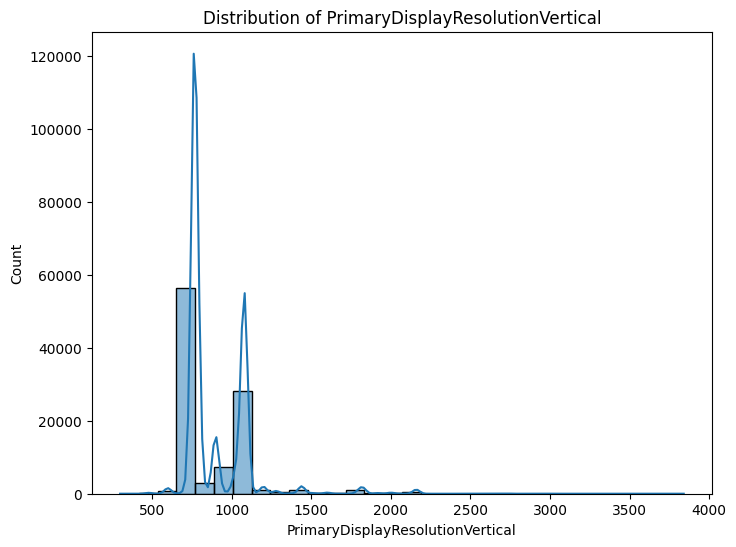

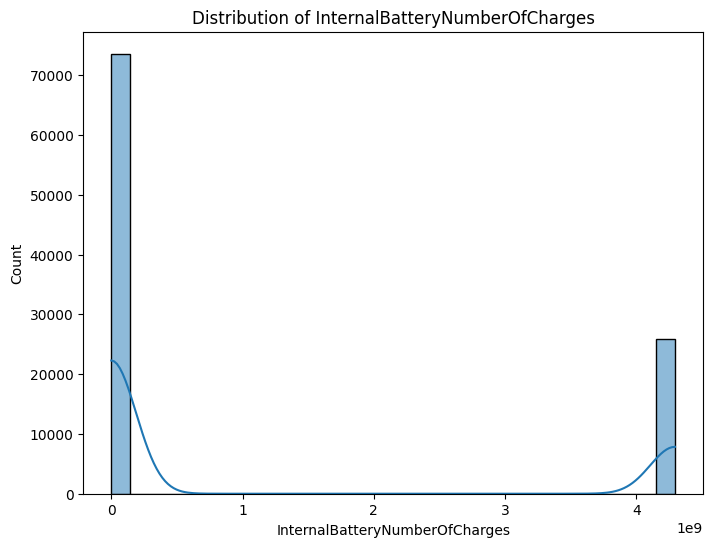

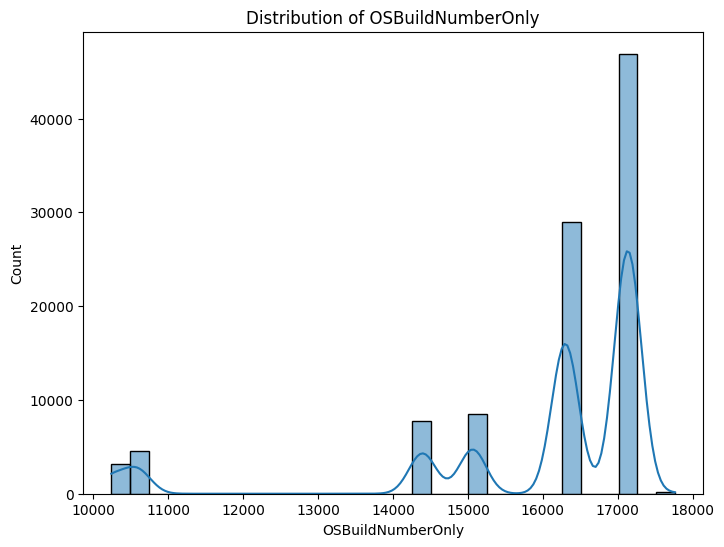

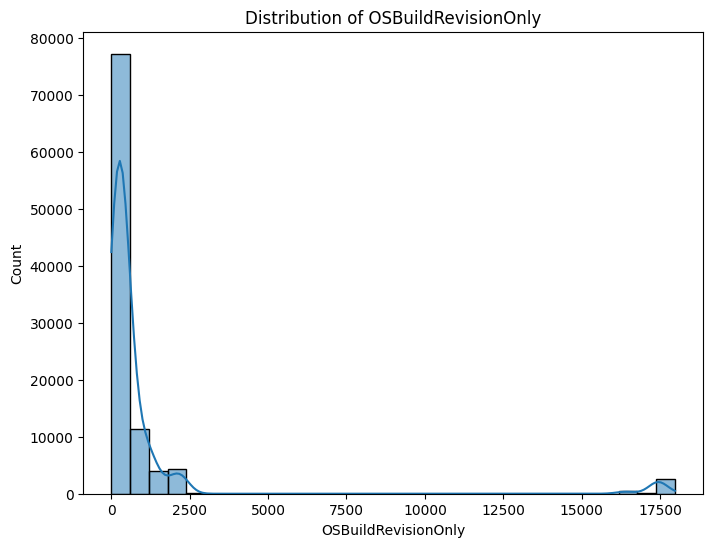

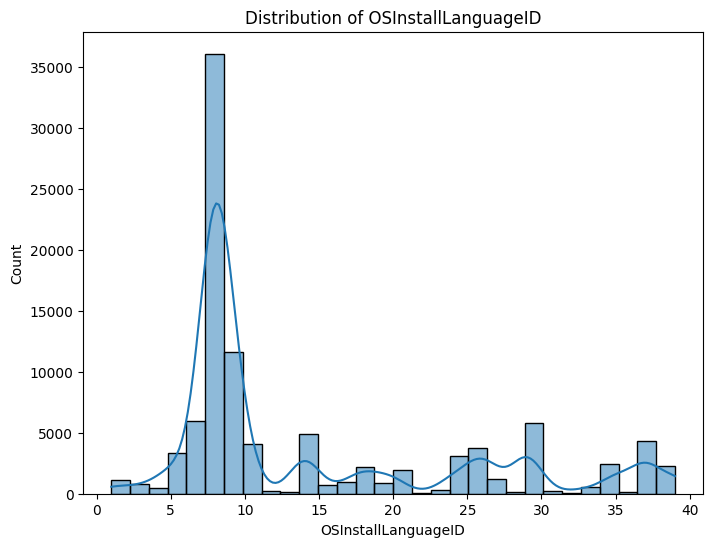

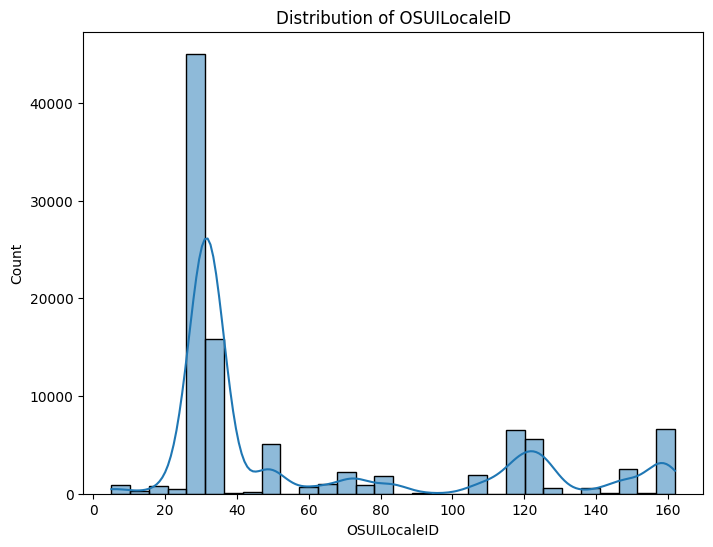

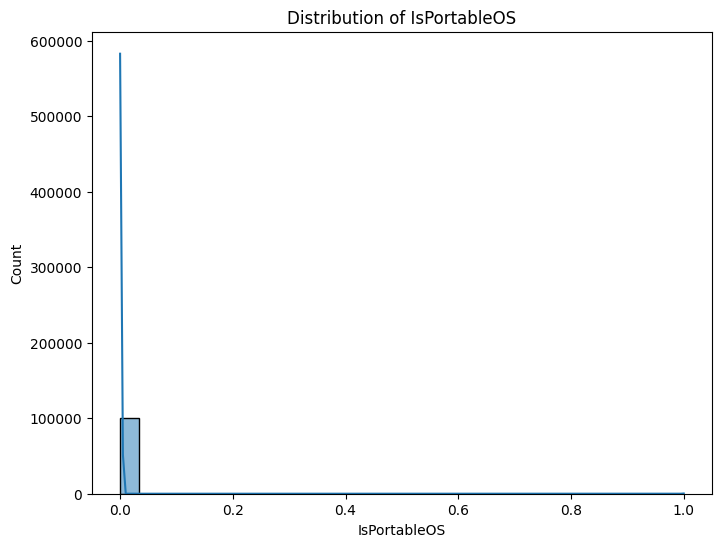

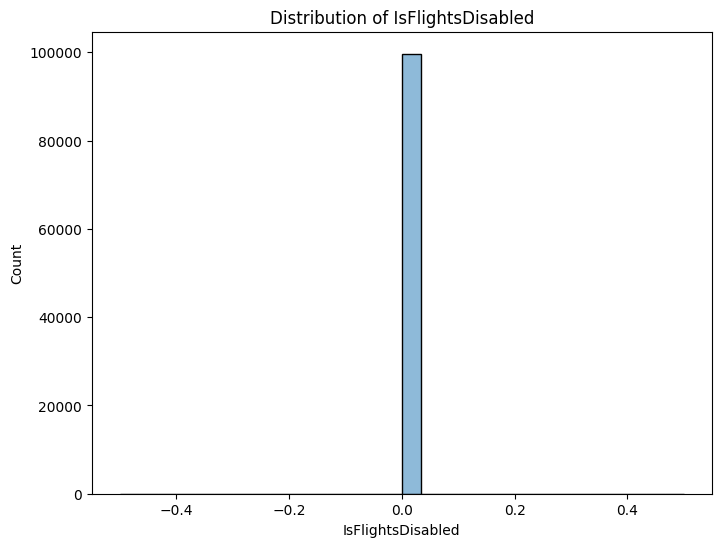

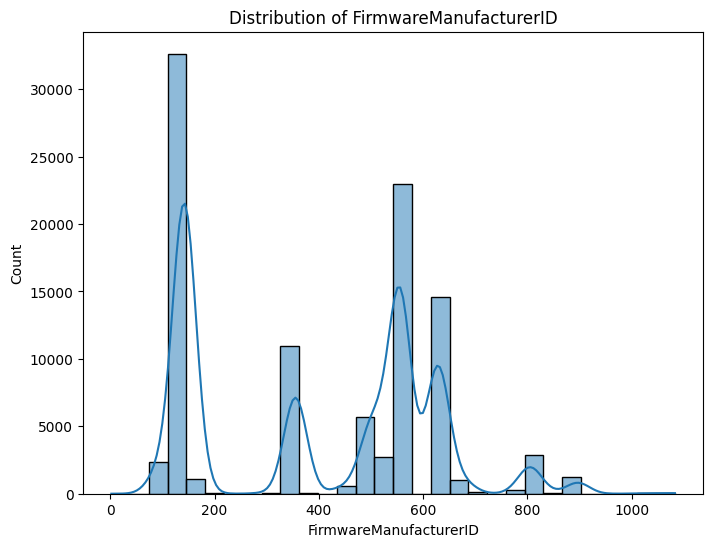

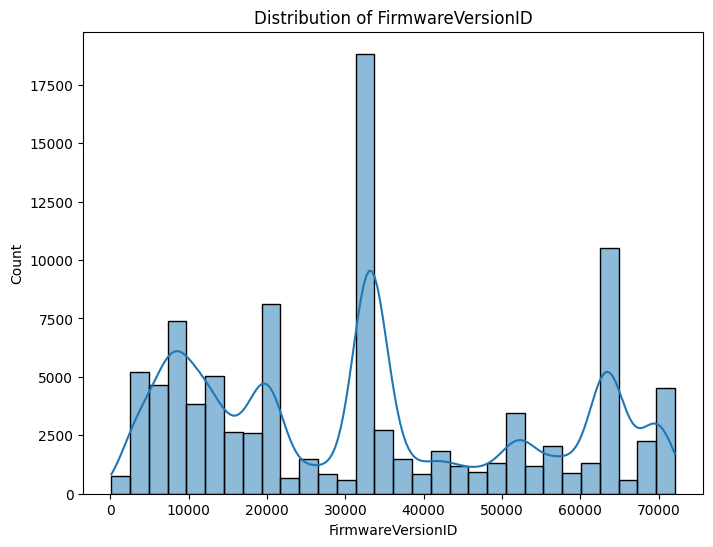

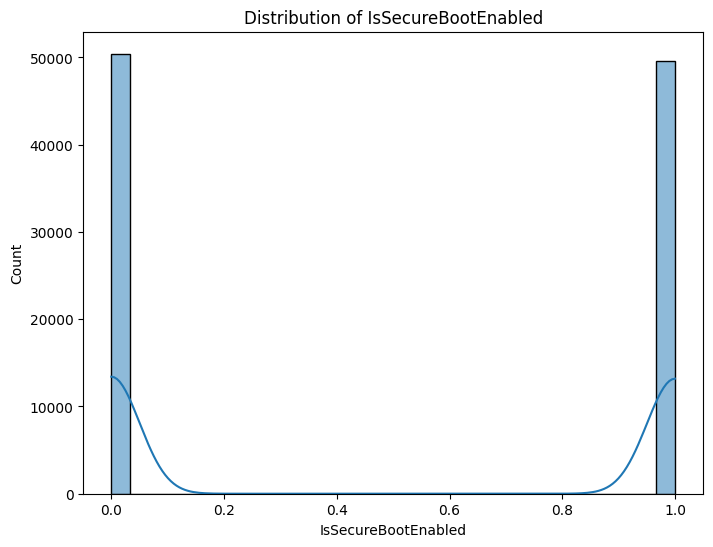

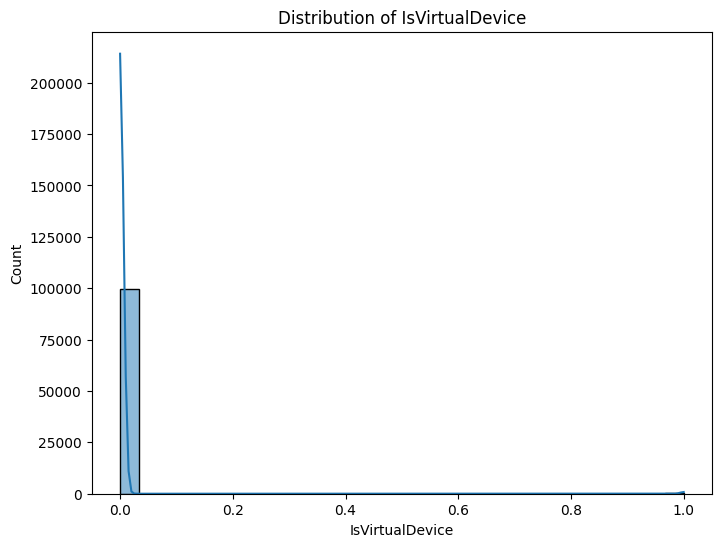

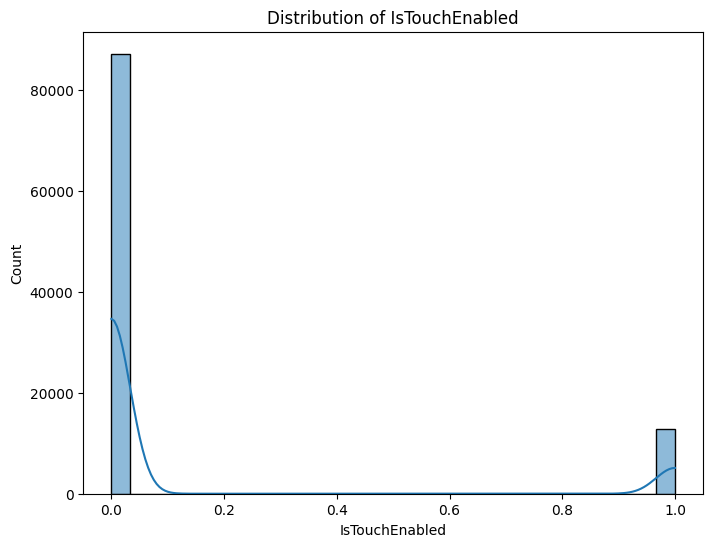

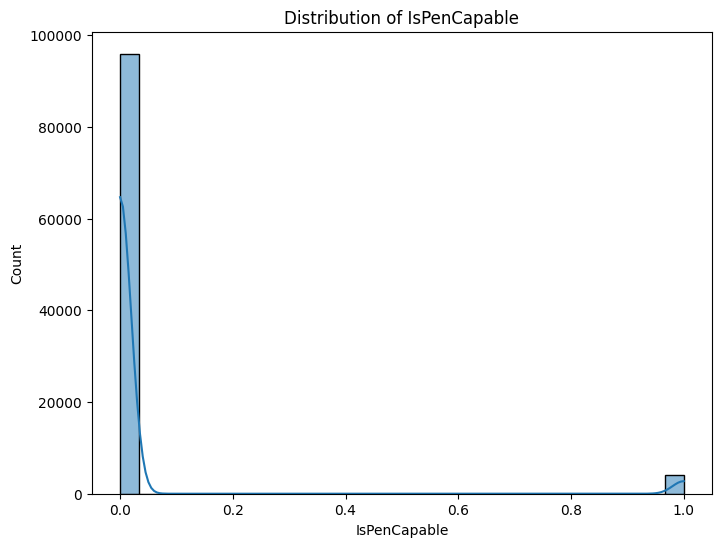

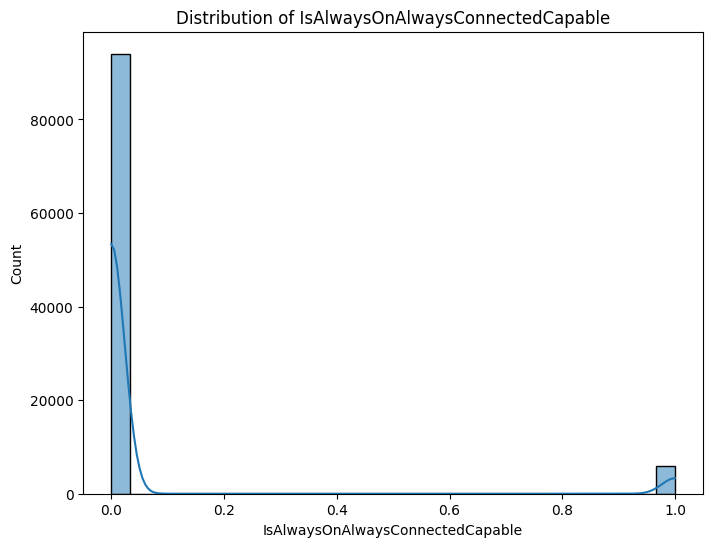

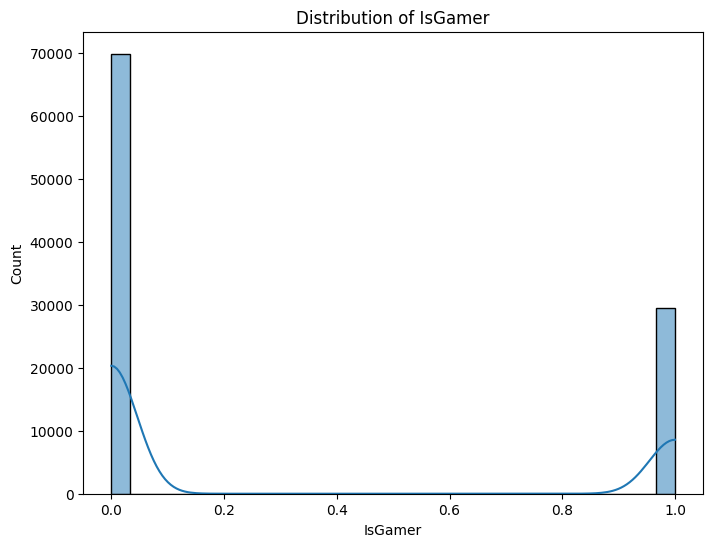

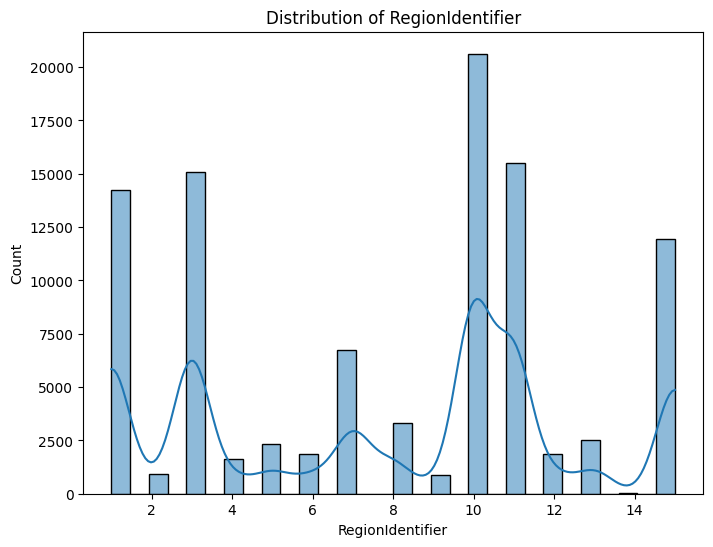

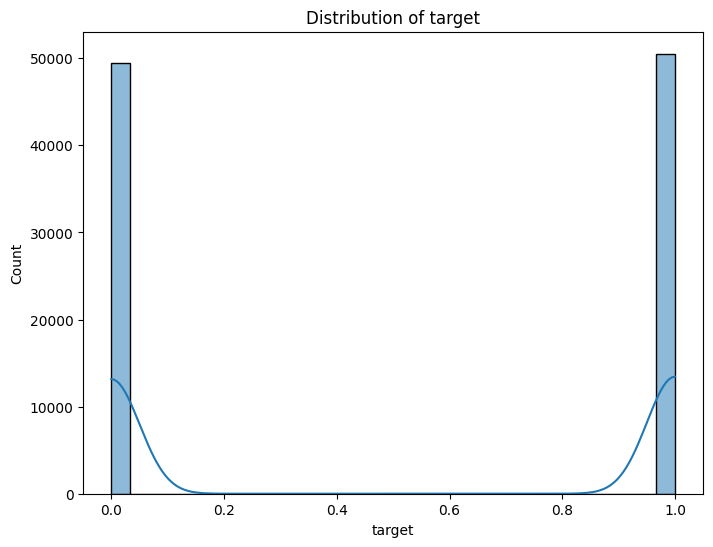

In [14]:
# Visualize distributions of numeric features using histograms
numeric_features = train_df.select_dtypes(include=['float64', 'int64']).columns
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(train_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()


**Detailed Visualization of  distribution of categorical features (top 5 most frequent)**

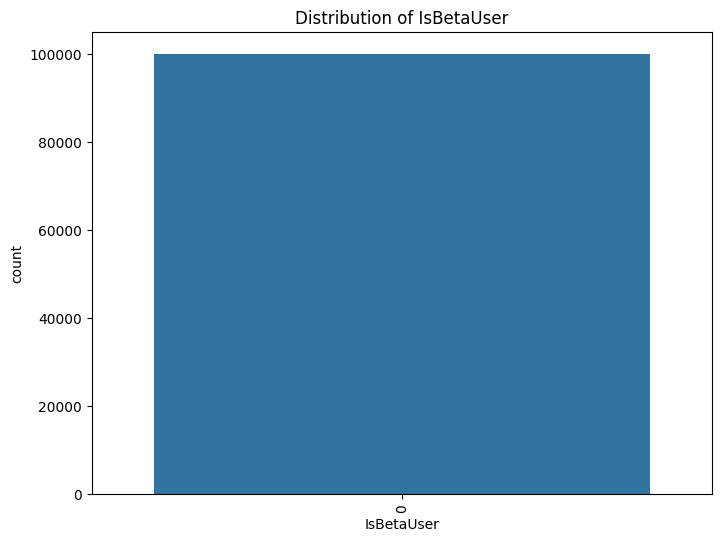

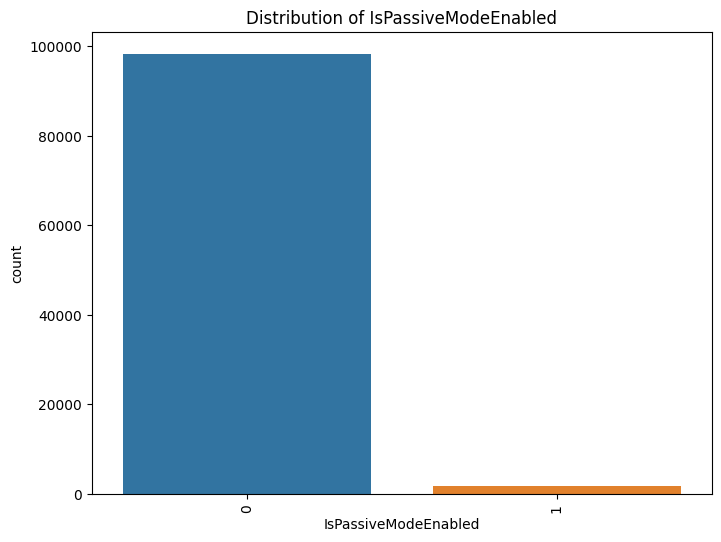

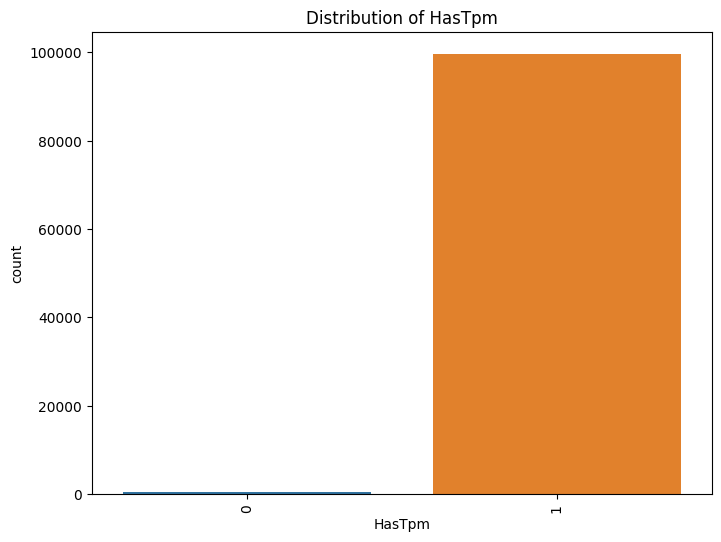

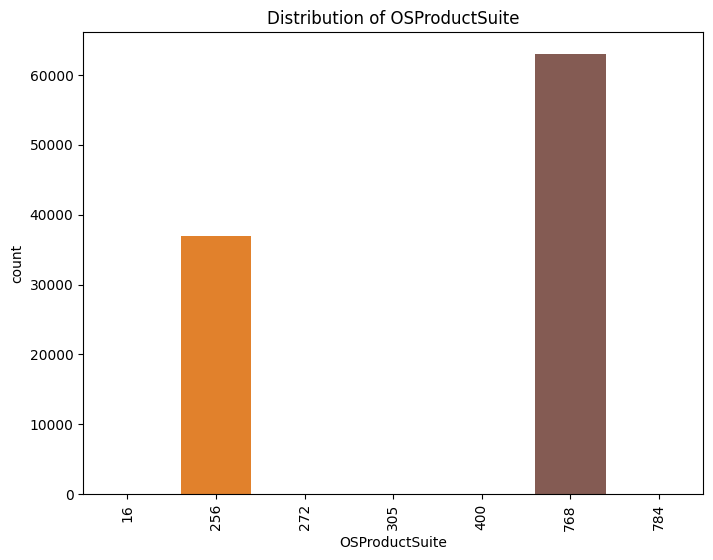

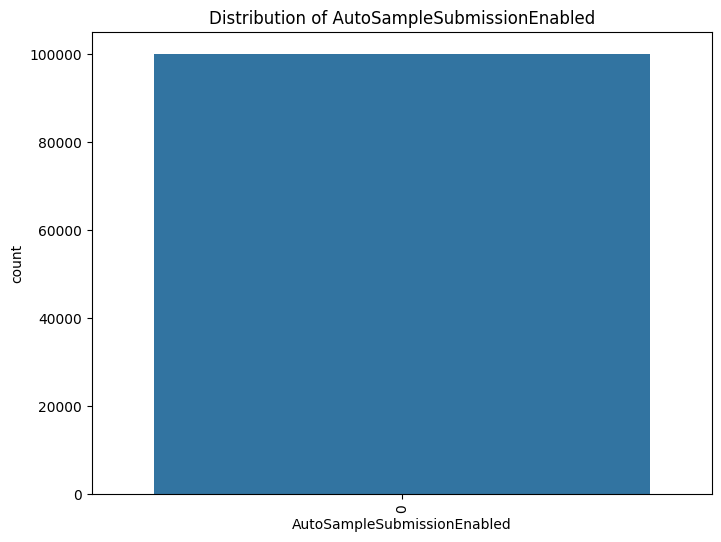

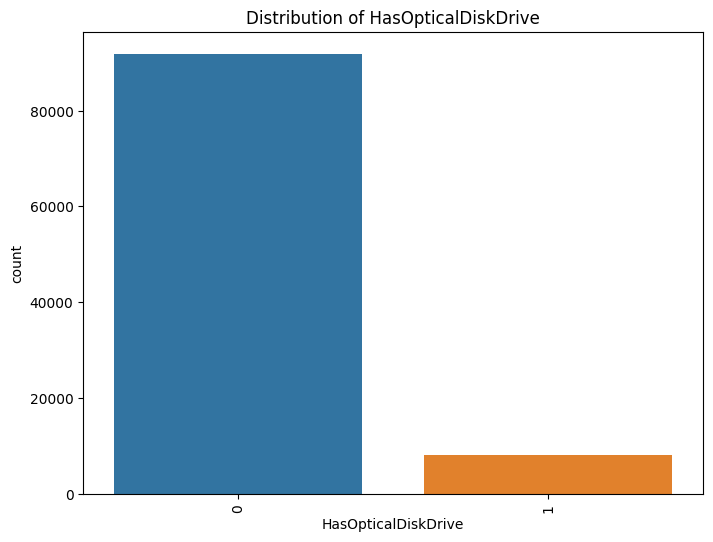

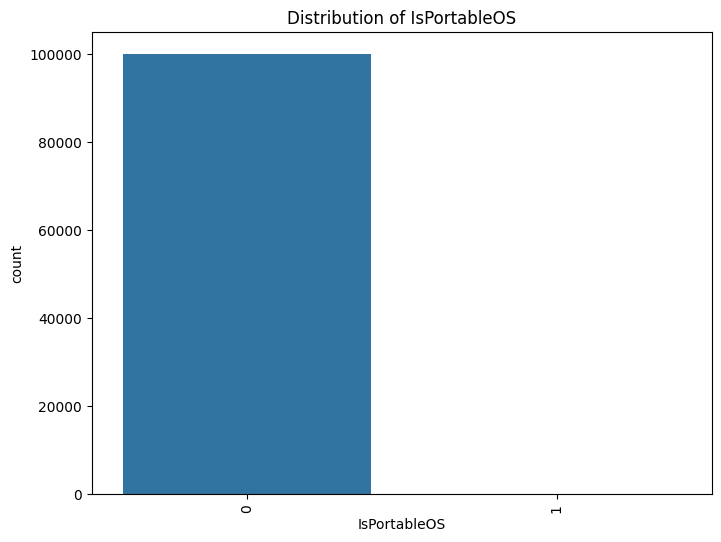

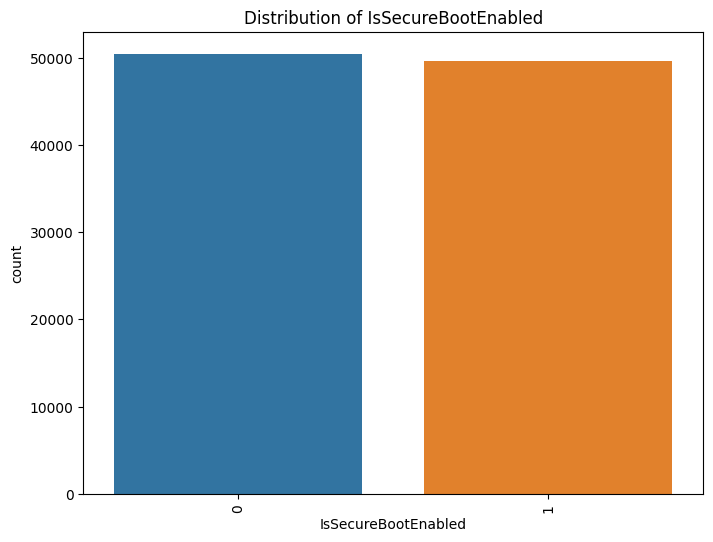

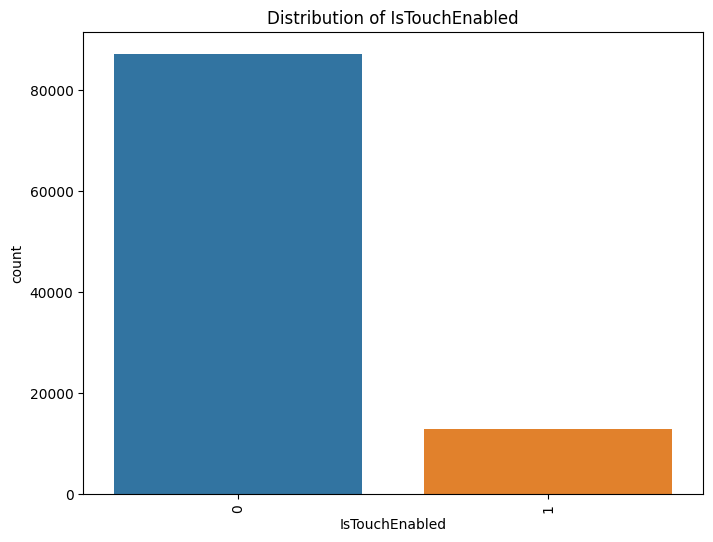

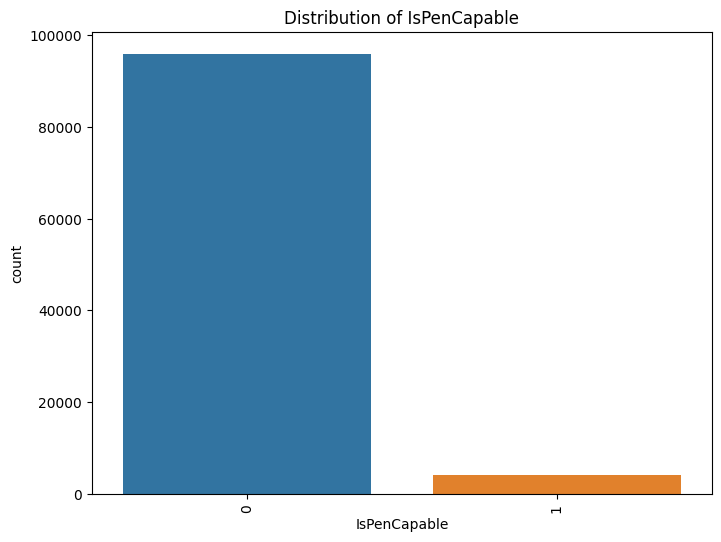

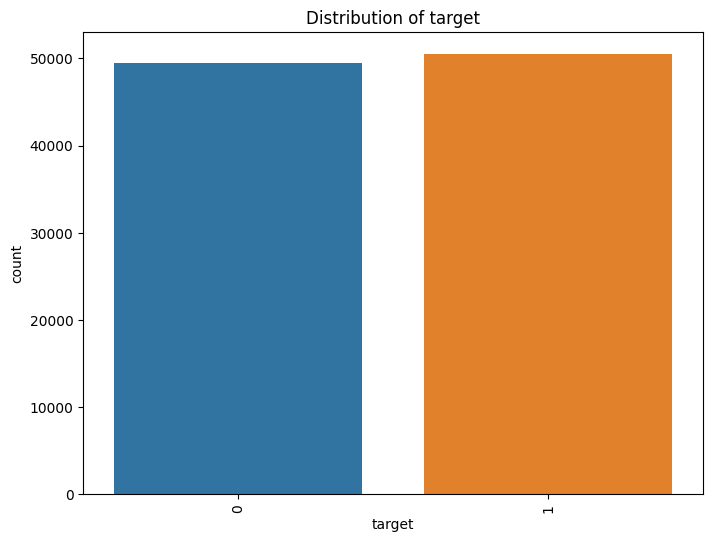

In [15]:
# Visualize distribution of categorical features (top 5 most frequent)
categorical_features = train_df.select_dtypes(include=['int64']).columns
for feature in categorical_features:
    if train_df[feature].nunique() < 20:  # Plot only for categorical features with fewer unique values
        plt.figure(figsize=(8, 6))
        sns.countplot(data=train_df, x=feature)
        plt.title(f'Distribution of {feature}')
        plt.xticks(rotation=90)
        plt.show()


**Outliers Detection for numerical columns**

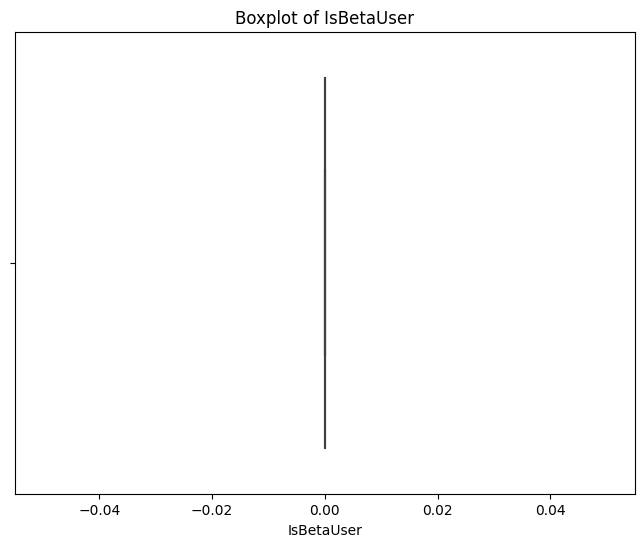

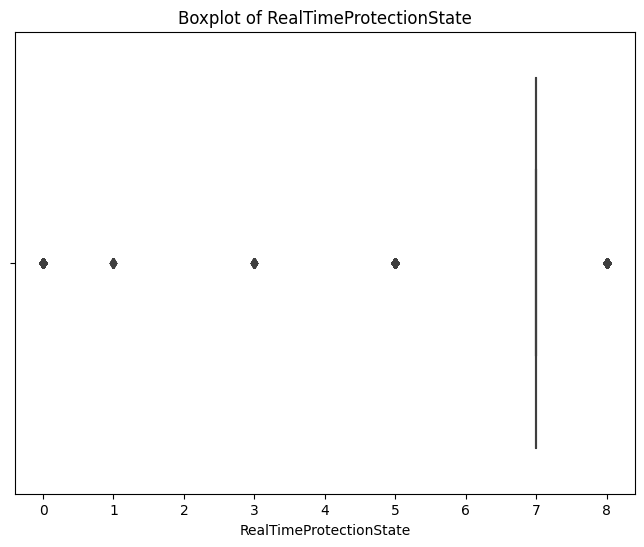

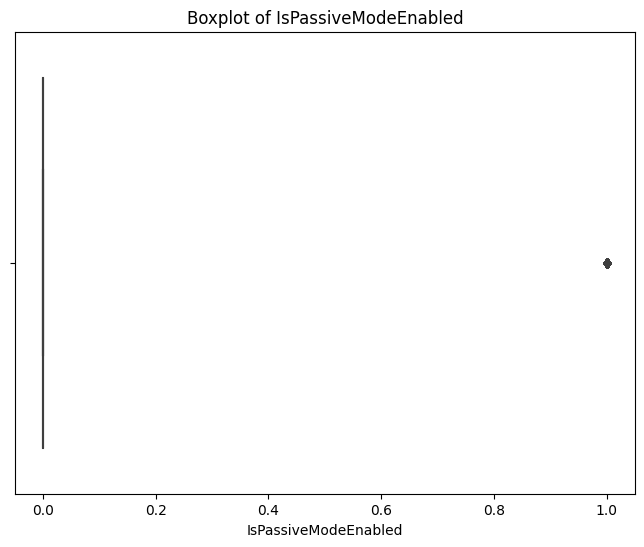

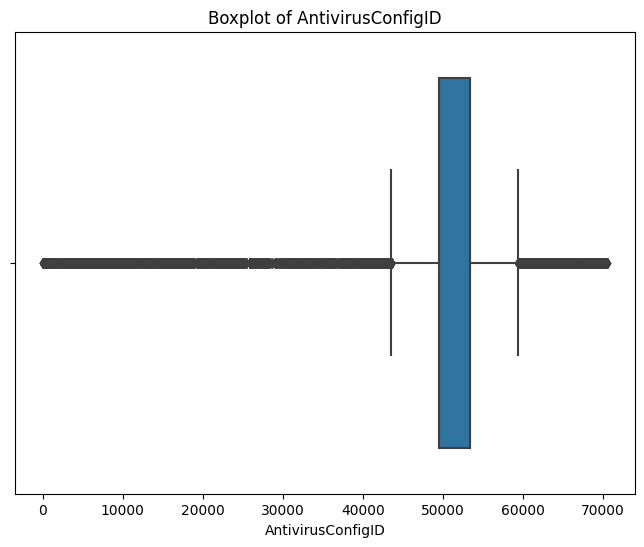

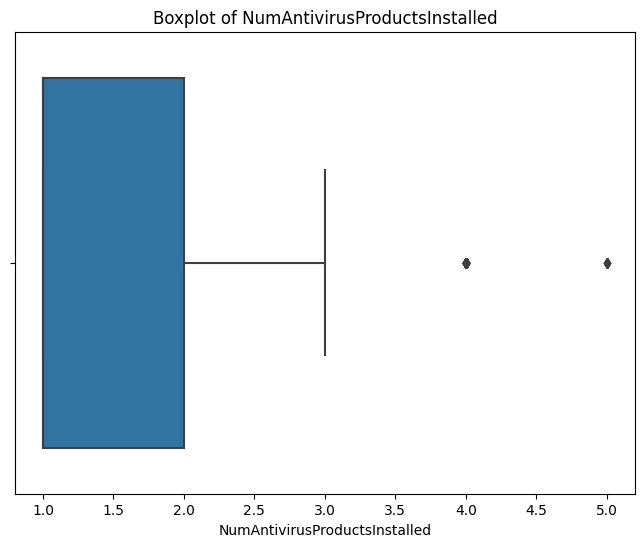

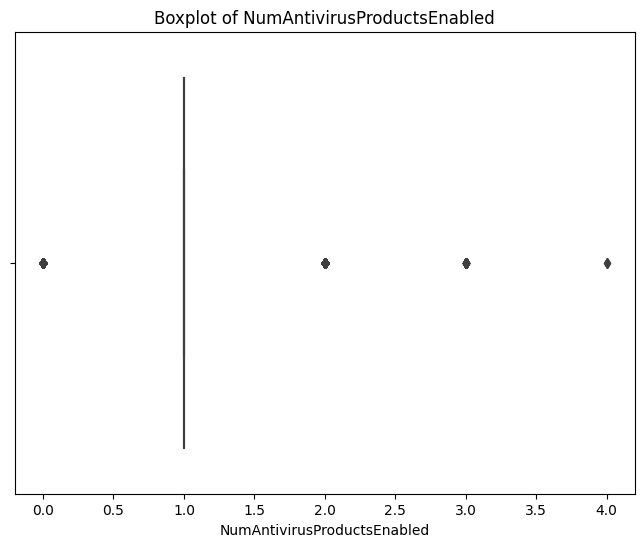

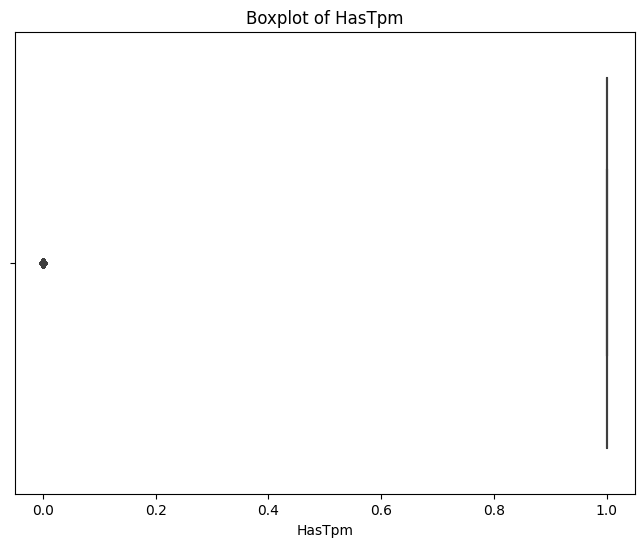

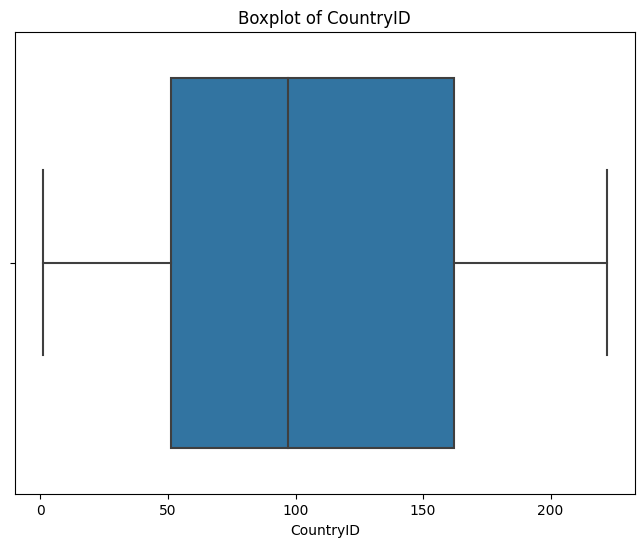

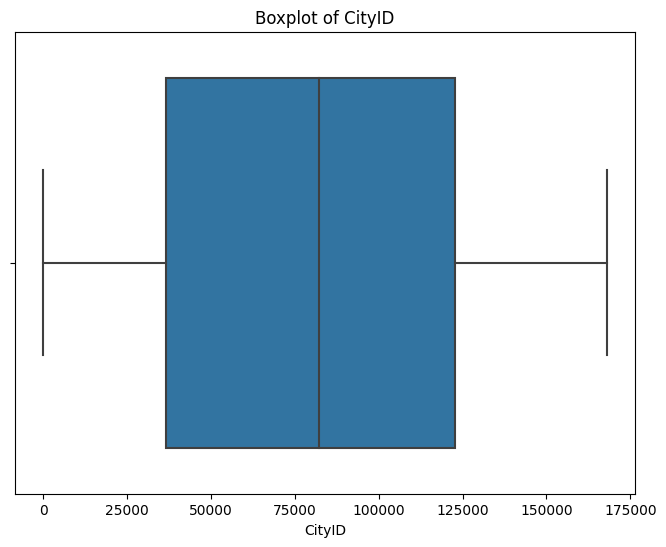

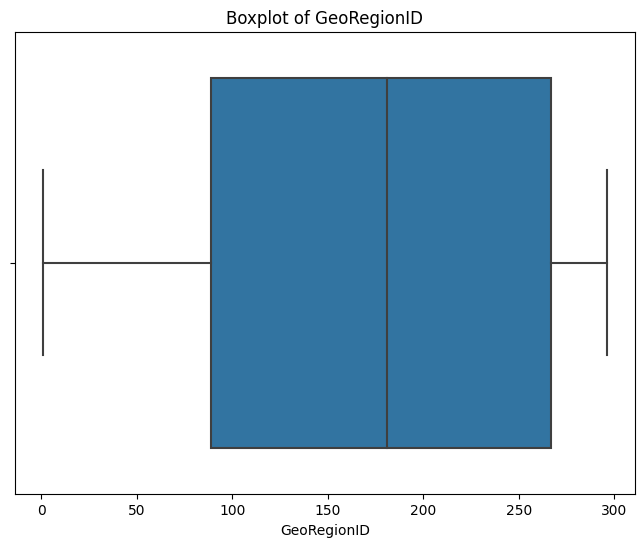

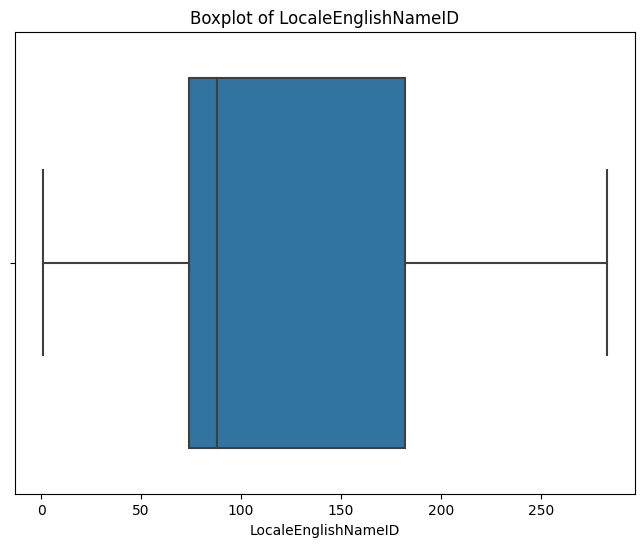

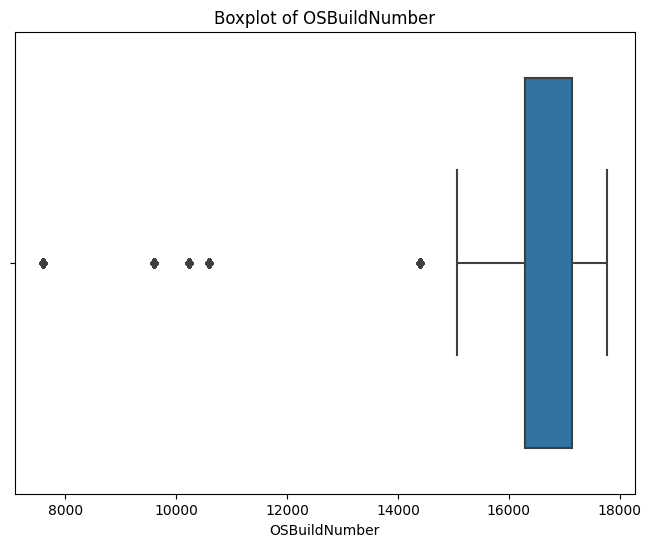

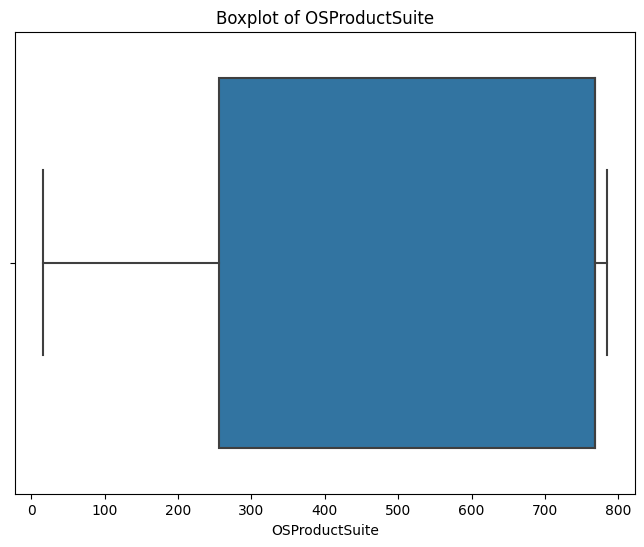

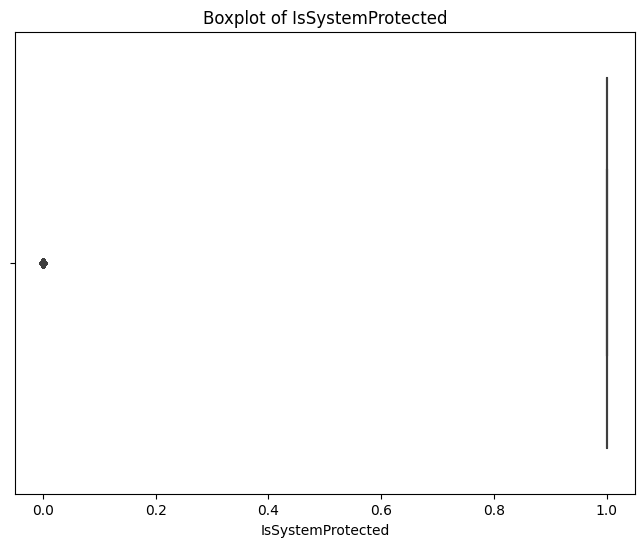

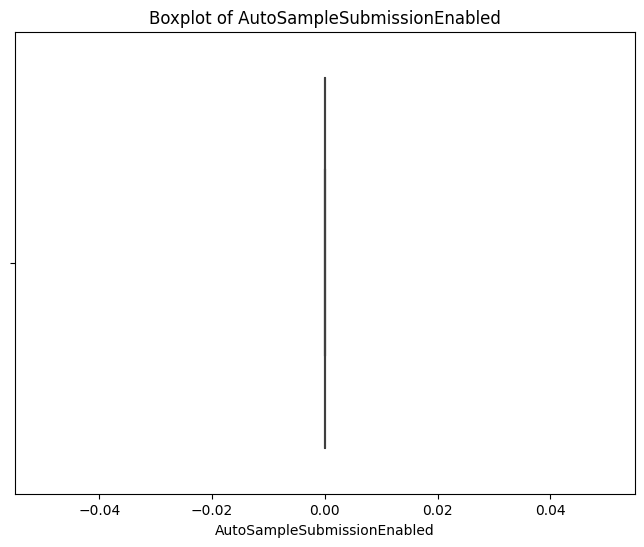

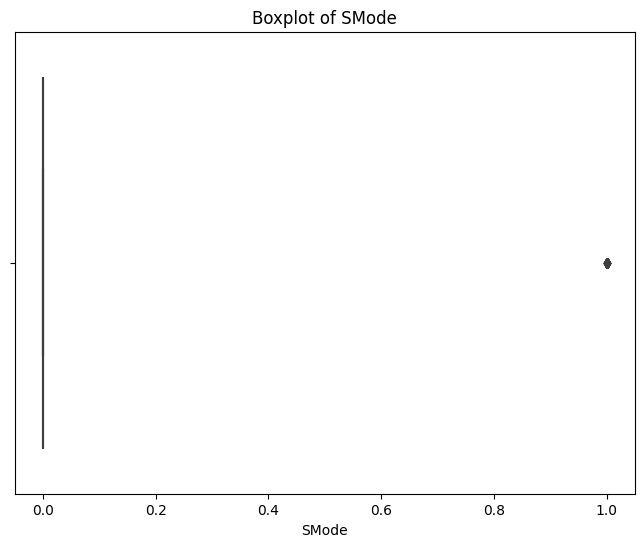

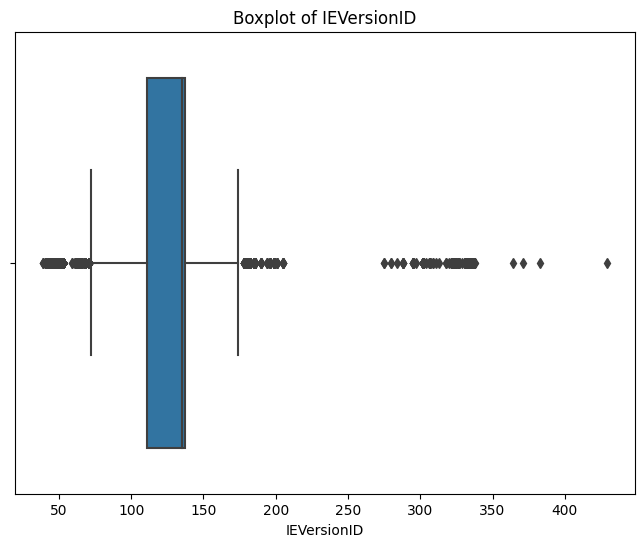

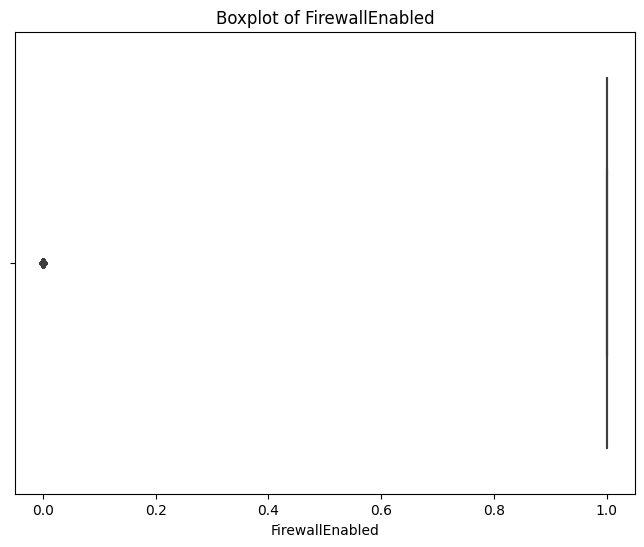

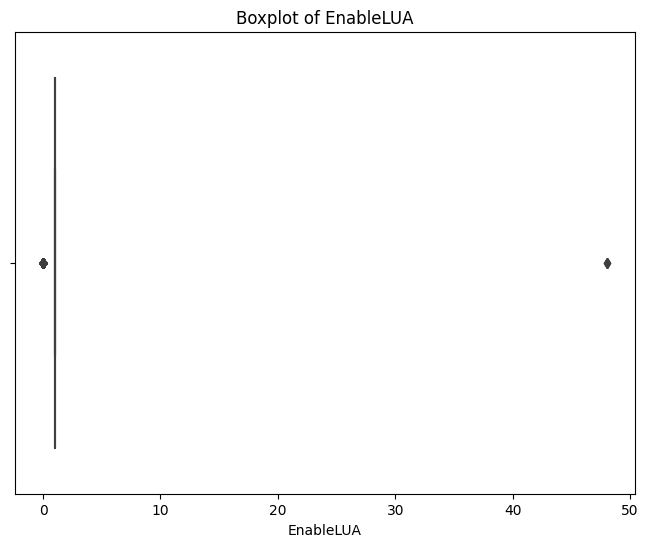

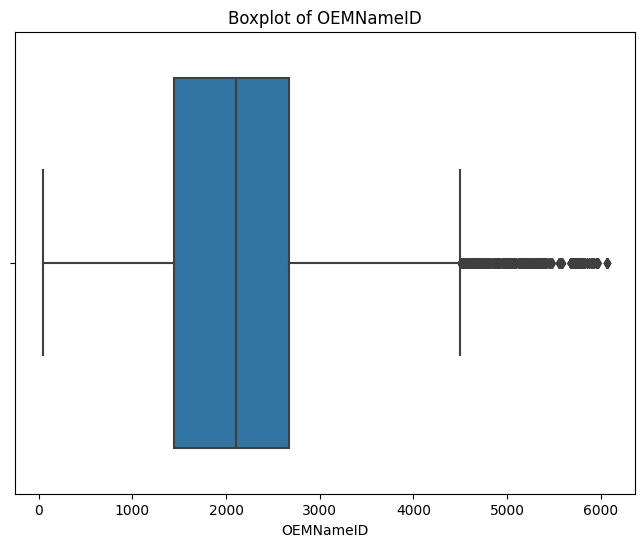

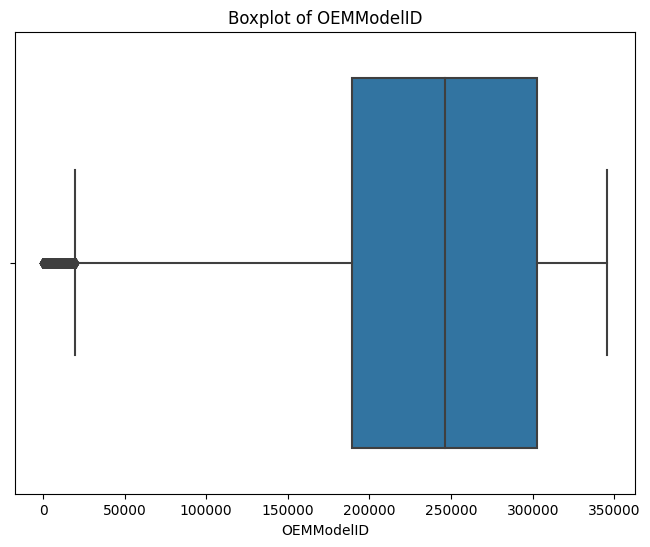

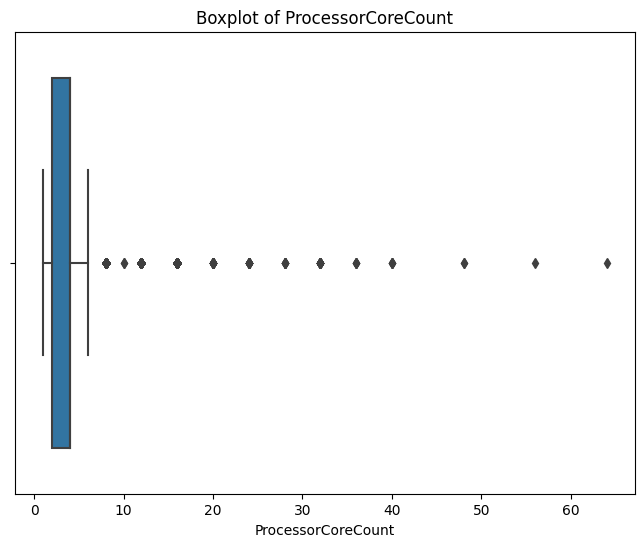

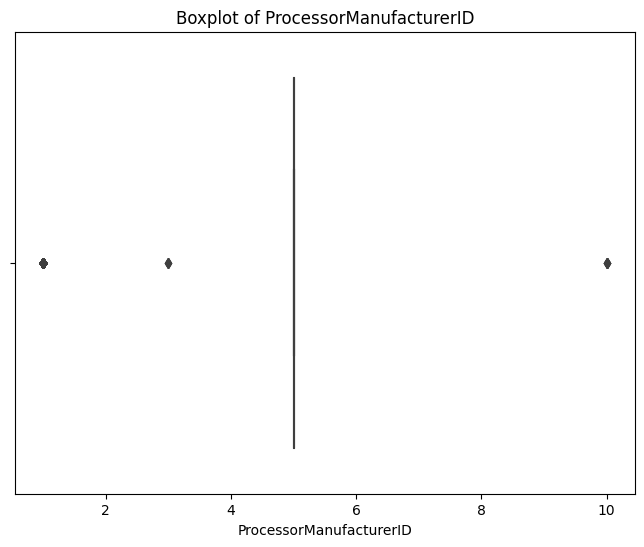

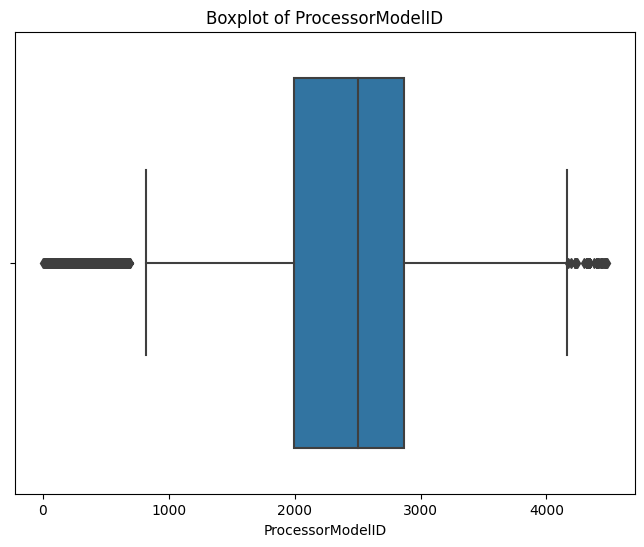

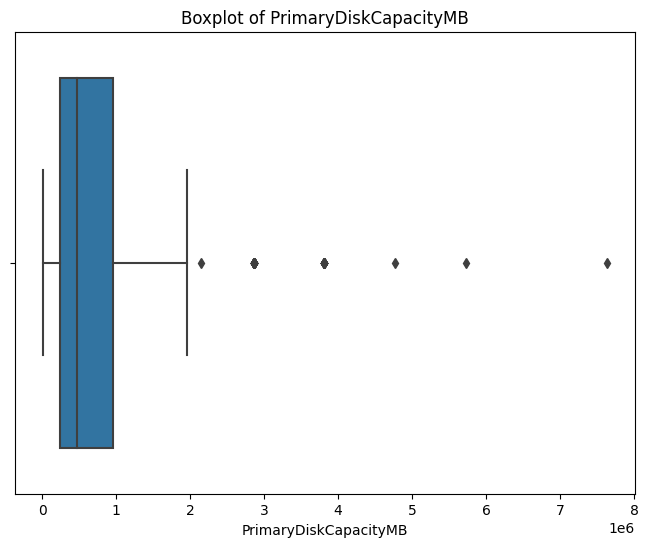

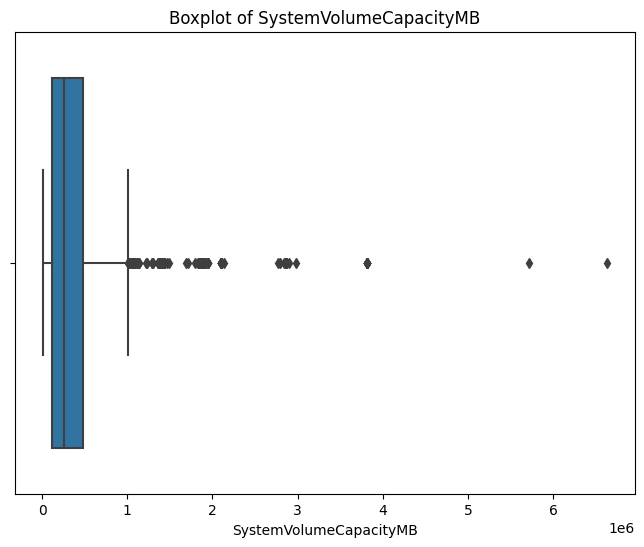

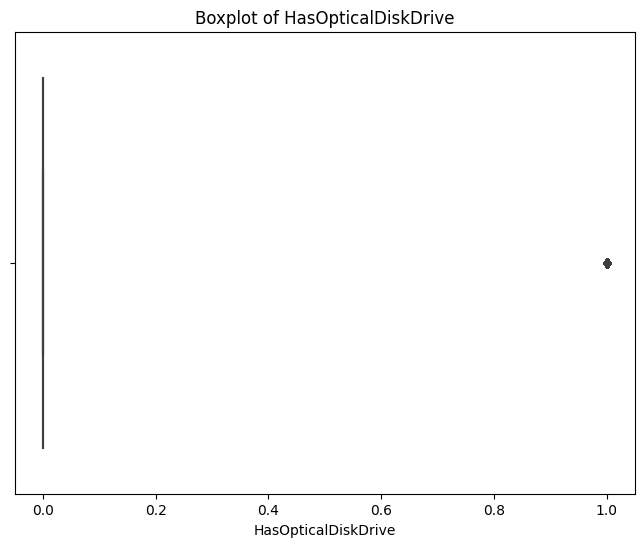

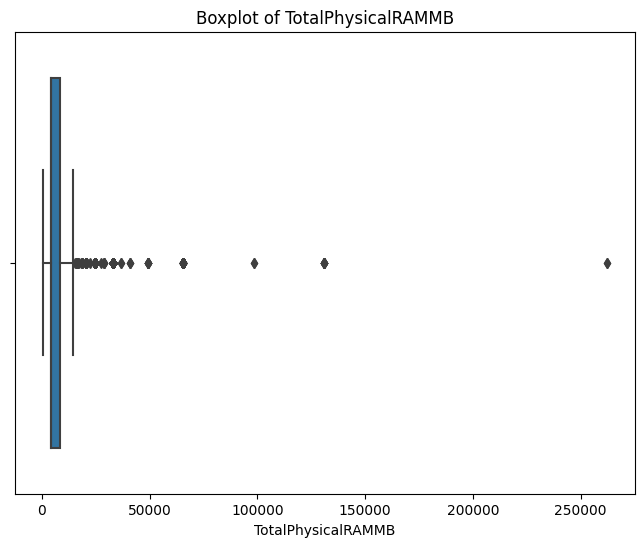

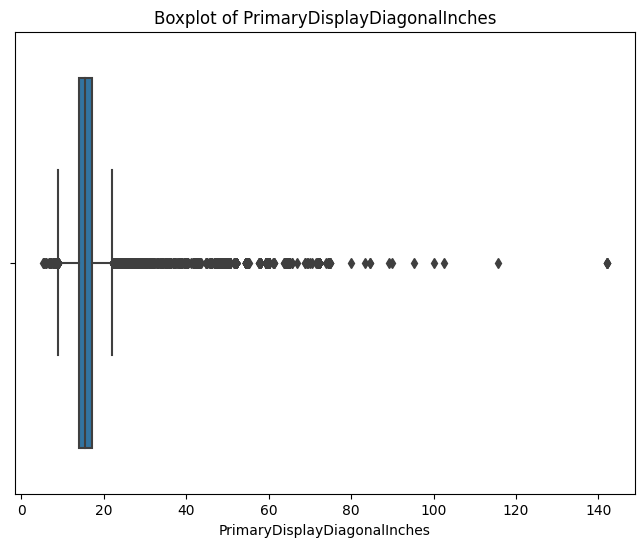

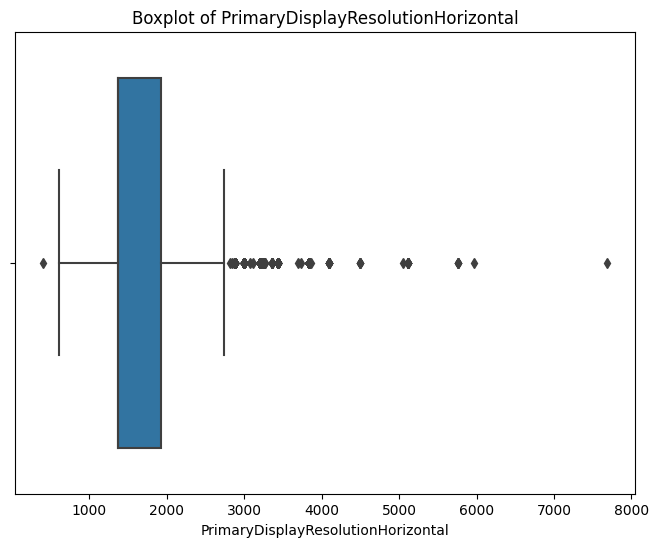

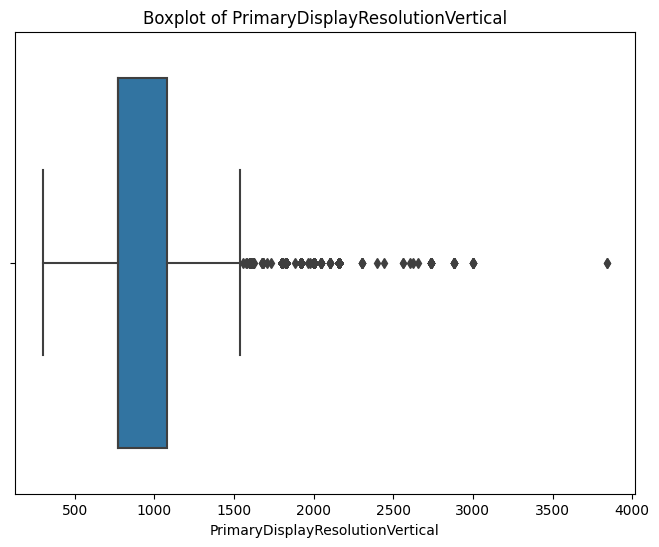

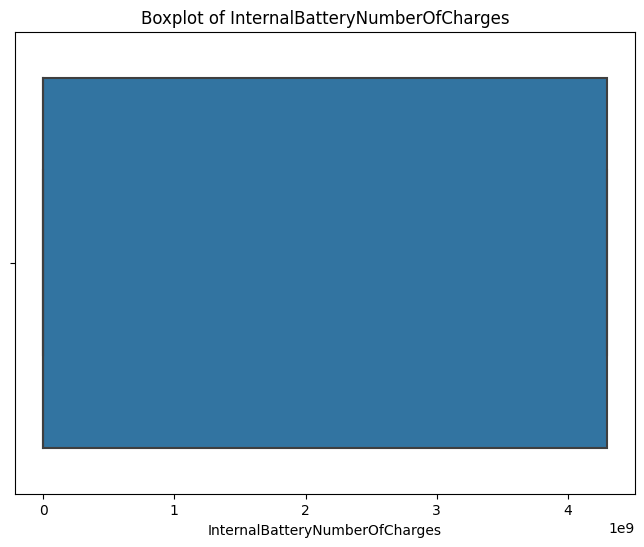

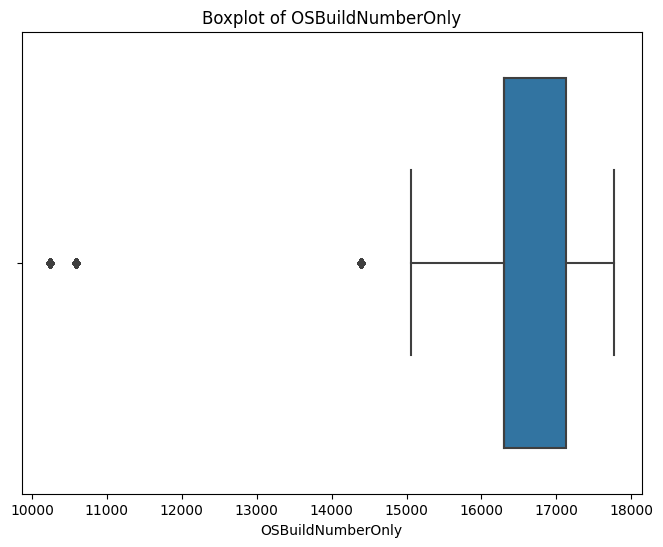

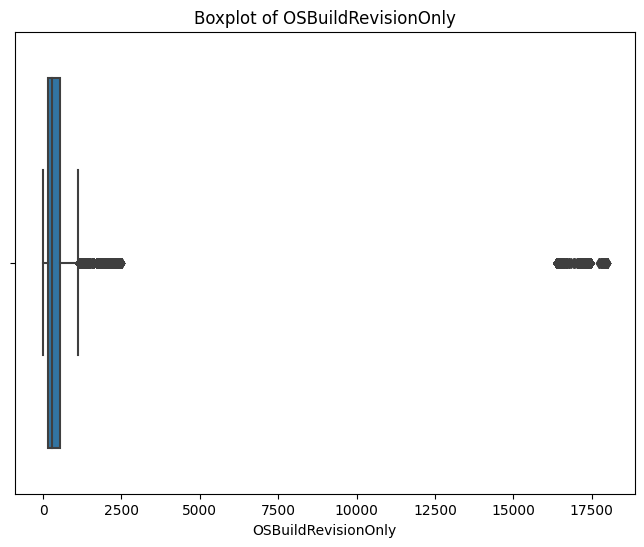

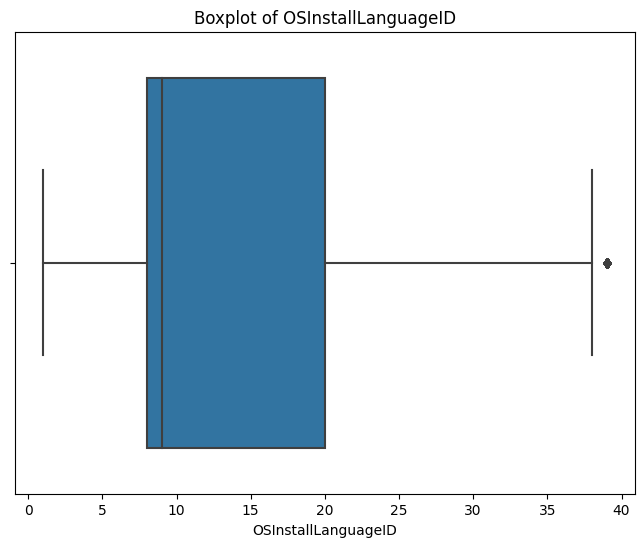

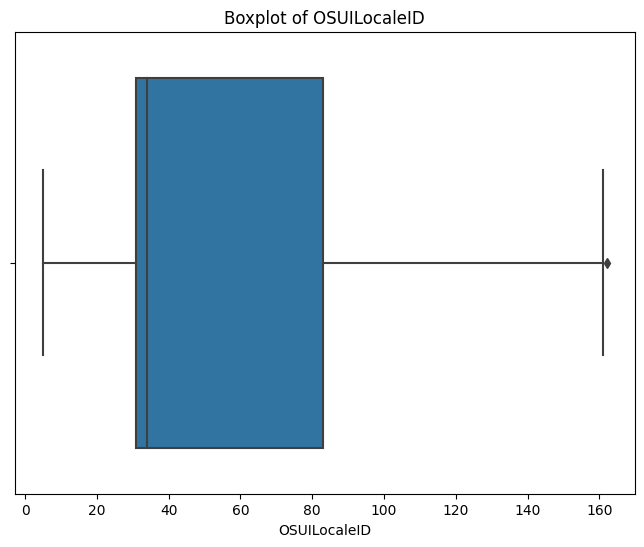

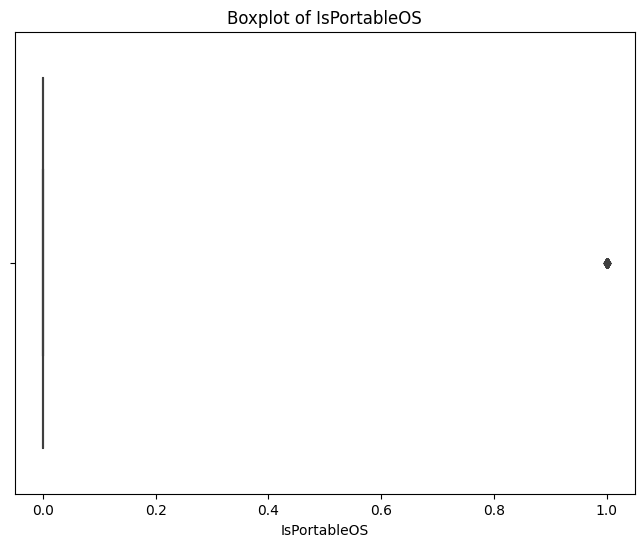

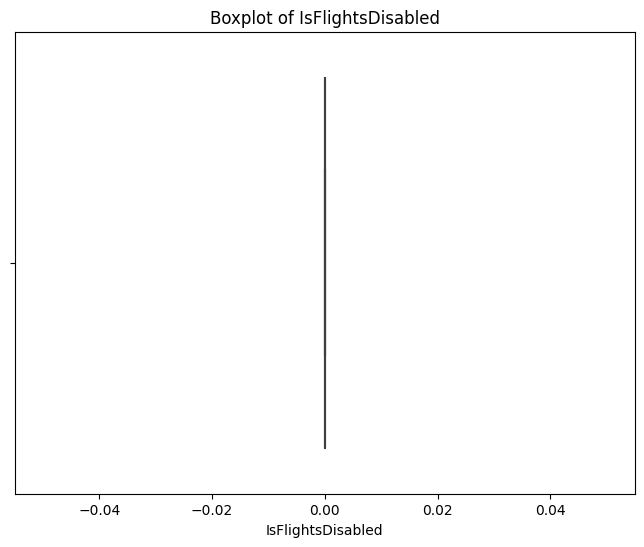

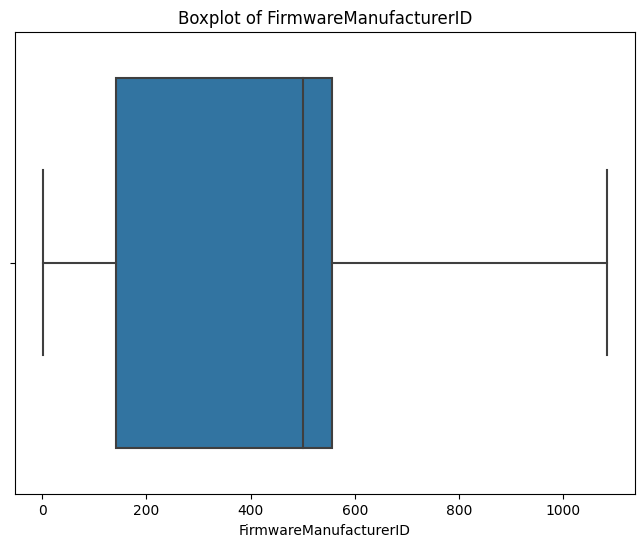

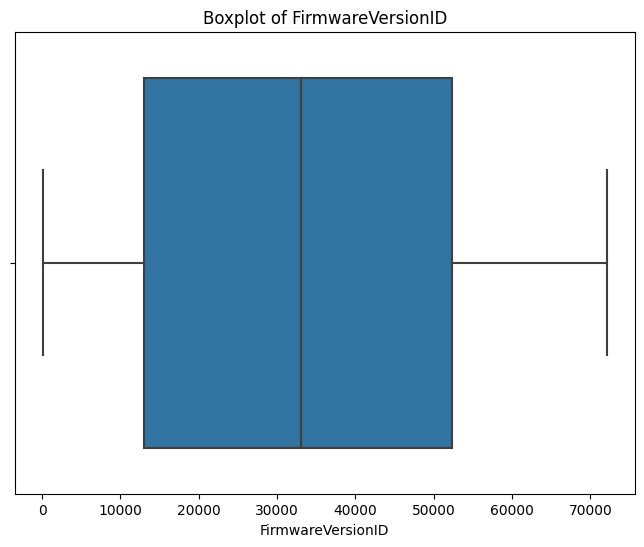

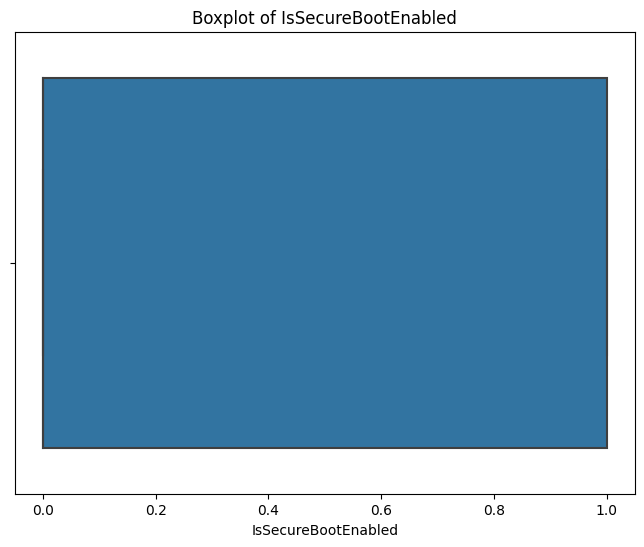

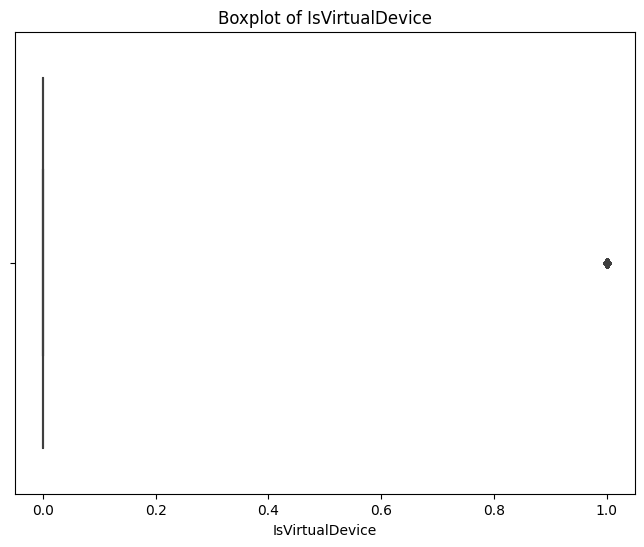

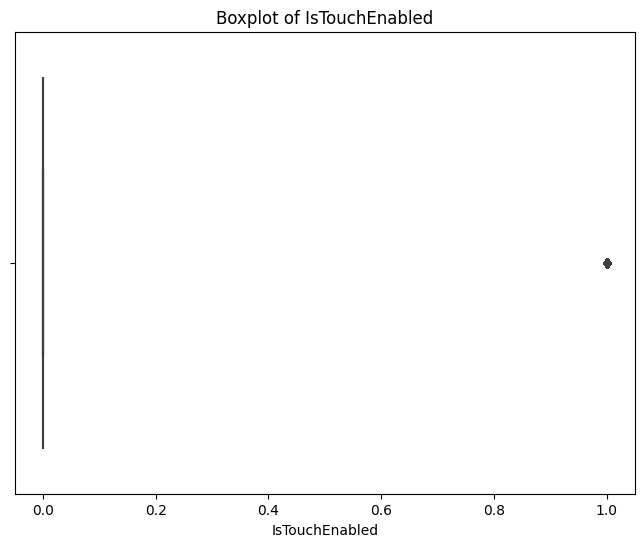

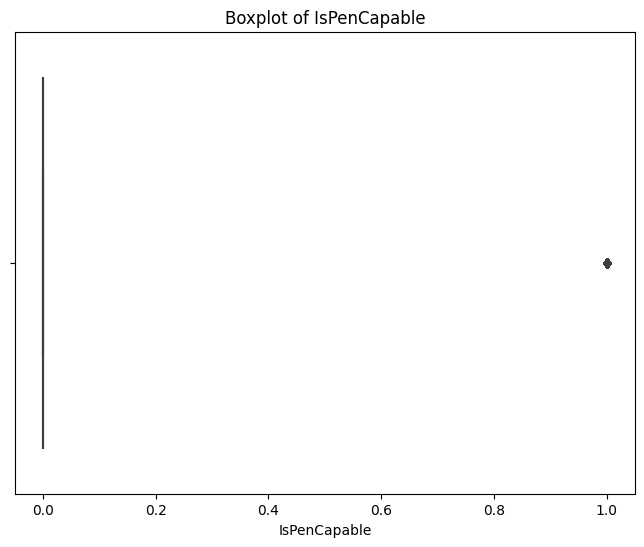

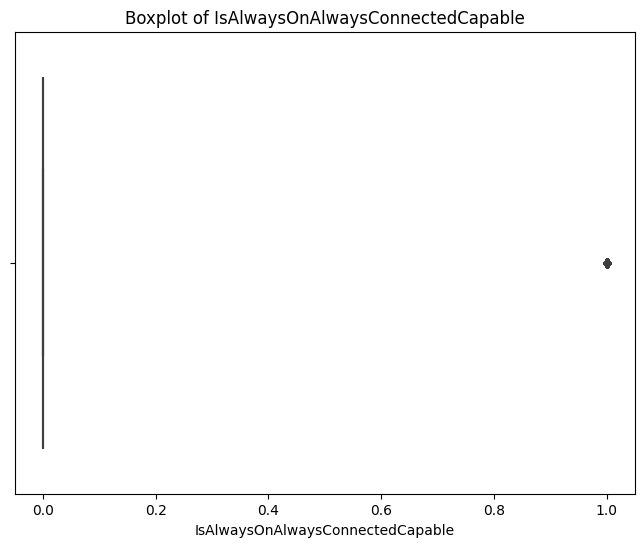

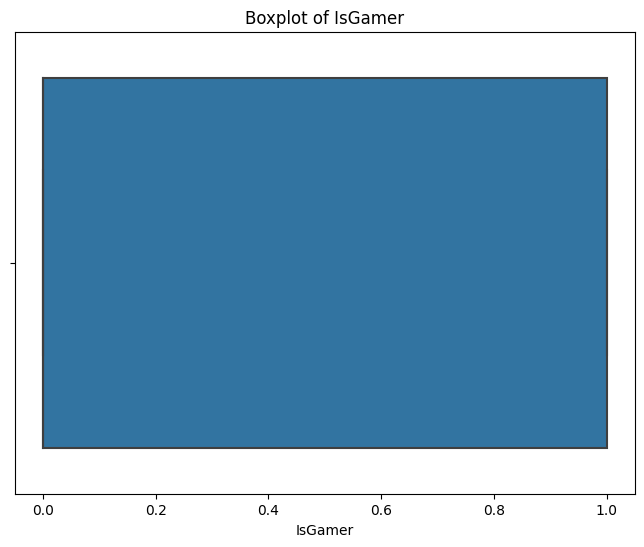

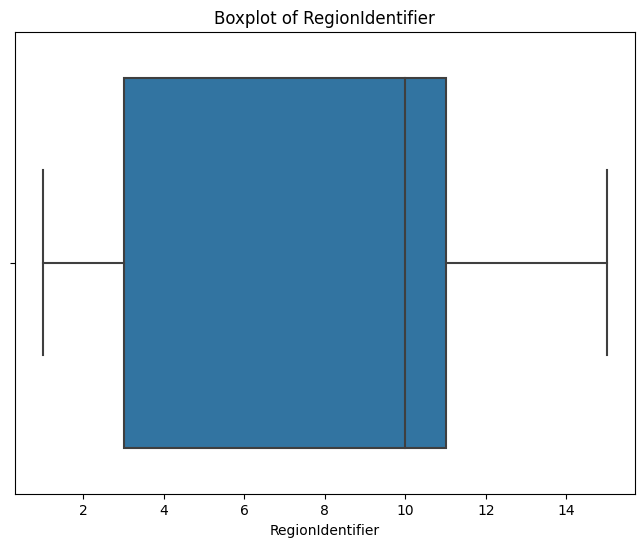

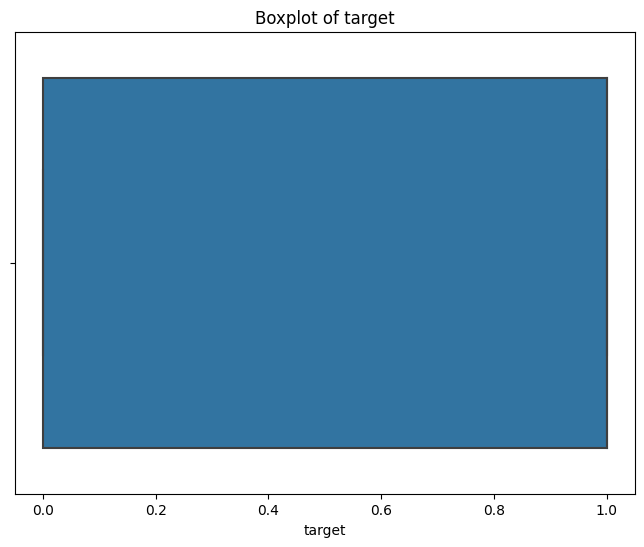

In [16]:
# Detect outliers using boxplots for numerical columns
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train_df, x=feature)
    plt.title(f'Boxplot of {feature}')
    plt.show()


# Data Preprocessing

**Detecting missing data and imputation**

In [17]:
from sklearn.impute import SimpleImputer

# Handle missing categorical values
if categorical_columns:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    for col in categorical_columns:
        train_df[col] = imputer_cat.fit_transform(train_df[[col]]).ravel()  # Convert to 1D
        test_df[col] = imputer_cat.transform(test_df[[col]]).ravel()
    print("Categorical missing values filled.")

# Handle missing numerical values
if numerical_columns:
    imputer_num = SimpleImputer(strategy='mean')
    train_df[numerical_columns] = imputer_num.fit_transform(train_df[numerical_columns])
    test_df[numerical_columns] = imputer_num.transform(test_df[numerical_columns])
    print("Numerical missing values filled.")

Categorical missing values filled.
Numerical missing values filled.



**Scaling numerical features using StandardScaler & Encoding categorical features using LabelEncoder.**


In [18]:
# Encode categorical columns
label_encoders = {}

if categorical_columns:
    for col in categorical_columns:
        le = LabelEncoder()
        combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
        le.fit(combined_data.astype(str))
        
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))
        
        label_encoders[col] = le
    
    print("Categorical features encoded.")


Categorical features encoded.


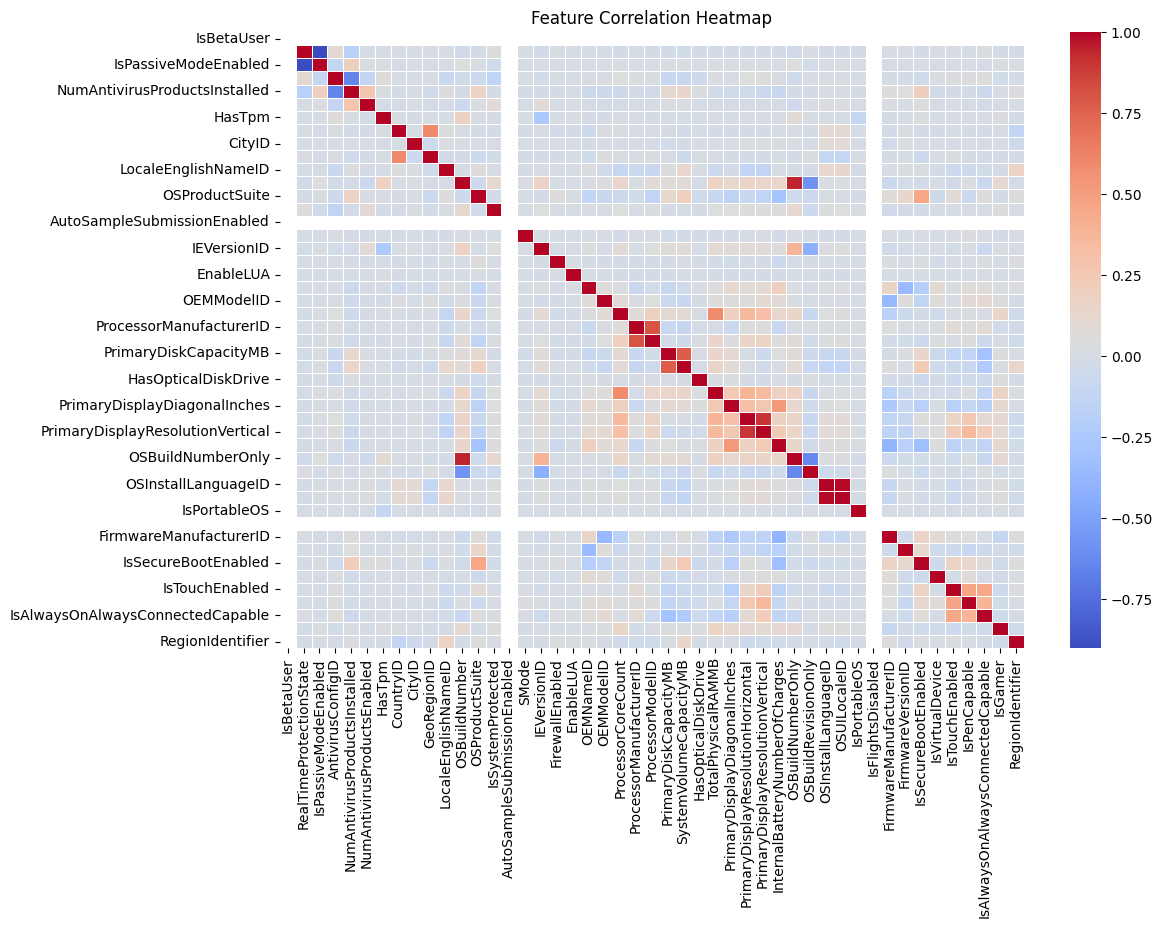

In [19]:
if numerical_columns:
    plt.figure(figsize=(12, 8))
    sns.heatmap(train_df[numerical_columns].corr(), cmap='coolwarm', annot=False, linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.show()

In [20]:
# Ensure 'target' column exists before proceeding
if 'target' not in train_df.columns:
    print("Error: 'target' column not found in training data.")
    exit()

# Separate features and target variable
X = train_df.drop(columns=['target'])
y = train_df['target']
X_test = test_df  # Test data has no target column

print("\nFeature and target variables prepared.")


Feature and target variables prepared.


In [21]:
# Feature Scaling
scaler = StandardScaler()

if numerical_columns:
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
    print("Feature scaling applied.")

Feature scaling applied.


# Feature engineering/extraction

In [22]:
# Feature Selection using Spearman Correlation
def select_features(X, y, num_features=50):
    correlations = {col: abs(spearmanr(X[col], y)[0]) for col in X.columns}
    selected_features = sorted(correlations, key=correlations.get, reverse=True)[:num_features]
    return X[selected_features], X_test[selected_features]

X_selected, X_test_selected = select_features(X, y, num_features=50)
print("Feature selection completed.")

Feature selection completed.


**(Spearman Correlation for feature selection )**

In [23]:
# Splitting data for model evaluation
X_train, X_valid, y_train, y_valid = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
print("Data split into training and validation sets.")

Data split into training and validation sets.


In [24]:
# Define Models
models = {
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}


In [25]:
# Cross-validation setup
NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

best_model = None
best_auc = 0
test_preds_ensemble = np.zeros(X_test_selected.shape[0])

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    oof_preds = np.zeros(X_selected.shape[0])
    test_preds = np.zeros(X_test_selected.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_selected, y)):
        X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test_selected)[:, 1] / NUM_FOLDS

    auc_score = roc_auc_score(y, oof_preds)
    print(f"{model_name} - AUC: {auc_score:.4f}")

    if auc_score > best_auc:
        best_auc = auc_score
        best_model = model_name
        test_preds_ensemble = test_preds

print(f"\nBest Model: {best_model} with AUC = {best_auc:.4f}")


Training LightGBM...
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3510
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 4

In [26]:
# Create Submission File
#submission = pd.DataFrame({'id': range(len(test_preds_ensemble)), 'target': (test_preds_ensemble > 0.5).astype(int)})
#submission.to_csv('submission.csv', index=False)
#print("\nSubmission file created: submission.csv")


Categorical columns: Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion',
       'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName',
       'MDC2FormFactor', 'DeviceFamily', 'PrimaryDiskType', 'ChassisType',
       'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch',
       'OSEdition', 'OSSkuFriendlyName', 'OSInstallType',
       'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'DateAS', 'DateOS'],
      dtype='object')


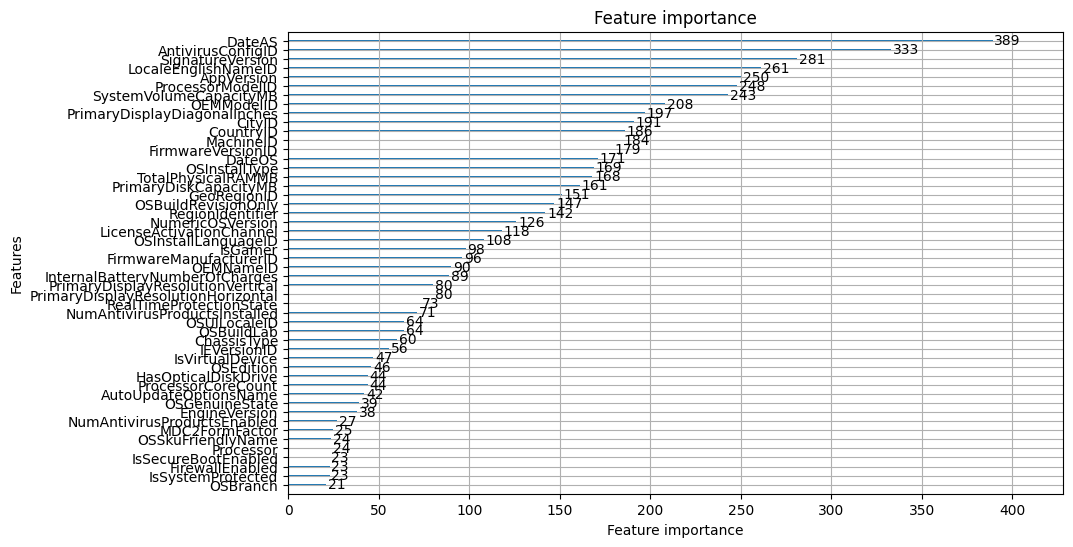


Fold 1
[200]	valid_0's binary_logloss: 0.63872

Fold 2
[200]	valid_0's binary_logloss: 0.637779

Fold 3
[200]	valid_0's binary_logloss: 0.642171

Fold 4
[200]	valid_0's binary_logloss: 0.642507

Fold 5
[200]	valid_0's binary_logloss: 0.641542

Validation metrics:
OOF Accuracy: 0.6298
OOF ROC AUC: 0.6812


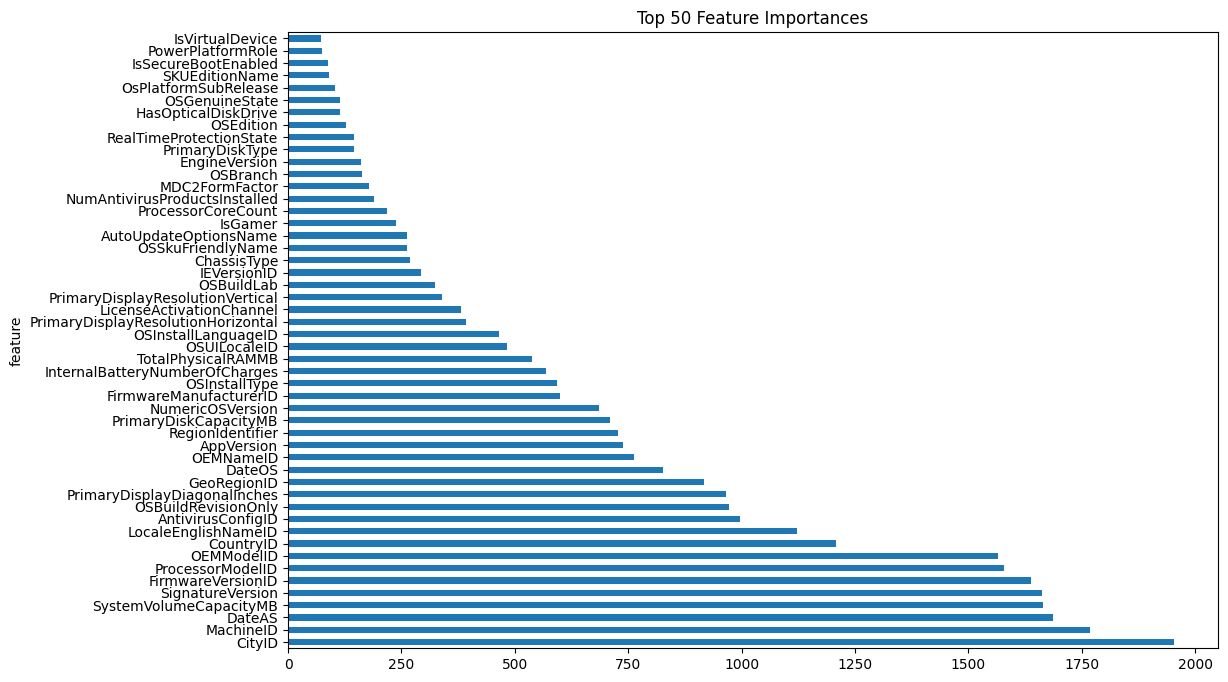


Submission file created: submission.csv


In [27]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# Identify categorical columns (non-numeric)
categorical_columns = train_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    
    # Combine both train and test columns for consistent encoding
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
    le.fit(combined_data.astype(str))  # Fit on the combined data (train + test)
    
    # Transform both train and test data using the same encoder
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    
    label_encoders[col] = le

# Separate features and target
X = train_df.drop(['target'], axis=1)
y = train_df['target']
X_test = test_df  # Test data does not have target column
test_ids = test_df['id'] if 'id' in test_df.columns else None

# Feature selection based on initial importance
def select_features(X, y, num_features=500):
    # Initial model for feature selection
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 63,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X, label=y)
    model = lgb.train(params, train_data, num_boost_round=100)
    
    # Plot feature importance
    lgb.plot_importance(model, max_num_features=50, figsize=(10, 6))
    plt.show()
    
    # Select top features based on importance
    importance = model.feature_importance(importance_type='gain')
    top_features = np.argsort(importance)[-num_features:]
    return X.iloc[:, top_features], X_test.iloc[:, top_features]

# Select important features
X_selected, X_test_selected = select_features(X, y, num_features=500)

# Final hyperparameters (optimized using cross-validation)
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.035,
    'num_leaves': 127,
    'max_depth': -1,
    'min_data_in_leaf': 25,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.2,
    'lambda_l2': 0.3,
    'verbose': -1,
    'early_stopping_round': 100,
}

# Cross-validation setup
NUM_FOLDS = 5
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
oof_preds = np.zeros(X_selected.shape[0])
test_preds = np.zeros(X_test_selected.shape[0])
feature_importances = pd.DataFrame()

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_selected, y)):
    print(f"\nFold {fold + 1}")
    X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=2000,
        callbacks=[lgb.log_evaluation(200)],
    )

    # Store predictions
    oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
    test_preds += model.predict(X_test_selected, num_iteration=model.best_iteration) / NUM_FOLDS

    # Track feature importance
    fold_importance = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': model.feature_importance(),
        'fold': fold
    })
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# Evaluate OOF predictions
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("\nValidation metrics:")
print(f"OOF Accuracy: {accuracy_score(y, oof_preds_binary):.4f}")
print(f"OOF ROC AUC: {roc_auc_score(y, oof_preds):.4f}")

# Analyze feature importance
mean_importance = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
mean_importance.head(50).plot(kind='barh', title='Top 50 Feature Importances')
plt.show()

# Create submission with artificial 'id' column
submission = pd.DataFrame({
    'id': range(len(test_preds)),  # Generate sequential ids
    'target': (test_preds > 0.5).astype(int)
})

# Save the submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")

hyperparameter tuning has improved the performance slightly in terms of the F1-score for Class 1, but the overall accuracy and metrics are still relatively similar to the initial results.

In [28]:
#X_test =pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [29]:
#X =df.drop("target" ,axis =1)
#y =df["target"]

In [30]:
#from sklearn.dummy import DummyClassifier
#model =DummyClassifier().fit(X,y)
#y_pred =model.predict(X_test)

In [31]:
#submission = pd.DataFrame({"id": range(0, X_test.shape[0]),
                           #"target": y_pred})
#submission.to_csv("submission.csv", index=False)


In [32]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score

# # Load the dataset
# train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Check the columns in your dataset
# print("Train columns:", train.columns)
# print("Test columns:", test.columns)

# # Identify the target column in the train dataset
# target_column = 'target'  # The correct target column name is 'target'

# # Check if the target column is in the train dataset
# if target_column not in train.columns:
#     raise KeyError(f"Target column '{target_column}' not found in train dataset.")

# # Separate features and target in the training data
# X_train = train.drop(columns=[target_column])
# y_train = train[target_column]

# # Identify the ID column (adjust if the column name is different)
# id_column = 'MachineID'  # Make sure this matches the exact column name in your test dataset

# # Separate test ID before preprocessing
# test_ids = test[id_column]

# # Combine train and test features for preprocessing
# combined_features = pd.concat([X_train, test.drop(columns=[id_column])], axis=0)

# # Data Preprocessing
# ## Handling Missing Values
# # Identify numerical and categorical columns
# num_cols = combined_features.select_dtypes(include=[np.number]).columns
# cat_cols = combined_features.select_dtypes(include=['object']).columns

# # Impute numerical columns
# num_imputer = SimpleImputer(strategy='median')
# combined_features[num_cols] = num_imputer.fit_transform(combined_features[num_cols])

# # Impute categorical columns
# cat_imputer = SimpleImputer(strategy='most_frequent')
# combined_features[cat_cols] = cat_imputer.fit_transform(combined_features[cat_cols])

# ## Label Encoding for categorical variables
# encoder = LabelEncoder()
# for col in cat_cols:
#     combined_features[col] = encoder.fit_transform(combined_features[col])

# # Feature Scaling
# scaler = StandardScaler()
# combined_features[num_cols] = scaler.fit_transform(combined_features[num_cols])

# # Split the features back into train and test
# X_train = combined_features.iloc[:len(X_train)]
# X_test = combined_features.iloc[len(X_train):]

# # Validation Split
# X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # AdaBoost Model
# ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
# ada_model.fit(X_train_split, y_train_split)

# # Make Predictions on Validation Set
# y_pred = ada_model.predict(X_val)

# # Accuracy Evaluation
# accuracy = accuracy_score(y_val, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")

# # Cross-Validation
# cross_val_accuracy = cross_val_score(ada_model, X_train, y_train, cv=5, scoring='accuracy')
# print(f"Cross-validated accuracy: {cross_val_accuracy.mean():.4f} ± {cross_val_accuracy.std():.4f}")

# # Prepare the final test predictions
# test_predictions = ada_model.predict(X_test)

# # Create submission DataFrame with unique IDs
# submission = pd.DataFrame({
#     'id': range(len(test_predictions)),  # Use sequential IDs
#     'target': test_predictions
# })

# # Save the submission file as CSV
# submission.to_csv('submission.csv', index=False)
# print("Submission file 'submission.csv' has been created.")

# # Optional: Verify submission format
# print("\nSubmission Preview:")
# print(submission.head())
# print("\nSubmission Info:")
# print(submission.info())

In [33]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score

# # Load the dataset
# train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify target and ID columns
# target_column = 'target'
# id_column = 'MachineID'

# # Separate features and target
# X_train = train.drop(columns=[target_column])
# y_train = train[target_column]
# test_ids = test[id_column]

# # Combine train and test features for preprocessing
# combined_features = pd.concat([X_train, test.drop(columns=[id_column])], axis=0)

# # Handling Missing Values
# num_cols = combined_features.select_dtypes(include=[np.number]).columns
# cat_cols = combined_features.select_dtypes(include=['object']).columns

# num_imputer = SimpleImputer(strategy='mean')
# combined_features[num_cols] = num_imputer.fit_transform(combined_features[num_cols])

# cat_imputer = SimpleImputer(strategy='most_frequent')
# combined_features[cat_cols] = cat_imputer.fit_transform(combined_features[cat_cols])

# # Label Encoding for categorical variables
# encoder = LabelEncoder()
# for col in cat_cols:
#     combined_features[col] = encoder.fit_transform(combined_features[col])

# # Feature Scaling
# scaler = StandardScaler()
# combined_features[num_cols] = scaler.fit_transform(combined_features[num_cols])

# # Split the features back into train and test
# X_train = combined_features.iloc[:len(X_train)]
# X_test = combined_features.iloc[len(X_train):]

# # Improved Model - Using RandomForest and GradientBoosting with AdaBoost
# X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Try different models
# rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
# gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

# rf_model.fit(X_train_split, y_train_split)
# gb_model.fit(X_train_split, y_train_split)

# rf_pred = rf_model.predict(X_val)
# gb_pred = gb_model.predict(X_val)

# # Evaluate models
# rf_accuracy = accuracy_score(y_val, rf_pred)
# gb_accuracy = accuracy_score(y_val, gb_pred)

# print(f"RandomForest Validation Accuracy: {rf_accuracy:.4f}")
# print(f"GradientBoosting Validation Accuracy: {gb_accuracy:.4f}")

# # Cross-Validation
# cv_rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
# cv_gb_accuracy = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')

# print(f"RF Cross-validated accuracy: {cv_rf_accuracy.mean():.4f} ± {cv_rf_accuracy.std():.4f}")
# print(f"GB Cross-validated accuracy: {cv_gb_accuracy.mean():.4f} ± {cv_gb_accuracy.std():.4f}")

# # Use the best model for final predictions
# final_model = gb_model if gb_accuracy > rf_accuracy else rf_model
# final_model.fit(X_train, y_train)
# test_predictions = final_model.predict(X_test)

# # Create submission file
# submission = pd.DataFrame({ 'id': range(len(test_predictions)), 'target': test_predictions })
# submission.to_csv('submission.csv', index=False)
# print("Improved submission file 'submission.csv' has been created.")

# # Verify submission format
# print(submission.head())
# print(submission.info())


In [34]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.impute import SimpleImputer
# import lightgbm as lgb
# from sklearn.metrics import accuracy_score

# # Load the dataset
# train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify target and ID columns
# target_column = 'target'
# id_column = 'MachineID'

# # Separate features and target
# X_train = train.drop(columns=[target_column])
# y_train = train[target_column]
# test_ids = test[id_column]

# # Combine train and test features for preprocessing
# combined_features = pd.concat([X_train, test.drop(columns=[id_column])], axis=0)

# # Handling Missing Values
# num_cols = combined_features.select_dtypes(include=[np.number]).columns
# cat_cols = combined_features.select_dtypes(include=['object']).columns

# num_imputer = SimpleImputer(strategy='mean')
# combined_features[num_cols] = num_imputer.fit_transform(combined_features[num_cols])

# cat_imputer = SimpleImputer(strategy='most_frequent')
# combined_features[cat_cols] = cat_imputer.fit_transform(combined_features[cat_cols])

# # Label Encoding for categorical variables
# encoder = LabelEncoder()
# for col in cat_cols:
#     combined_features[col] = encoder.fit_transform(combined_features[col])

# # Feature Scaling
# scaler = StandardScaler()
# combined_features[num_cols] = scaler.fit_transform(combined_features[num_cols])

# # Split the features back into train and test
# X_train = combined_features.iloc[:len(X_train)]
# X_test = combined_features.iloc[len(X_train):]

# # Train and validation split
# X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # LightGBM Model
# lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

# lgb_model.fit(X_train_split, y_train_split)

# # Predictions
# lgb_pred = lgb_model.predict(X_val)

# # Evaluate model
# lgb_accuracy = accuracy_score(y_val, lgb_pred)
# print(f"LightGBM Validation Accuracy: {lgb_accuracy:.4f}")

# # Cross-Validation
# cv_lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
# print(f"LightGBM Cross-validated accuracy: {cv_lgb_accuracy.mean():.4f} ± {cv_lgb_accuracy.std():.4f}")

# # Final model training
# lgb_model.fit(X_train, y_train)

# # Test predictions
# test_predictions = lgb_model.predict(X_test)

# # Create submission file
# submission = pd.DataFrame({ 'id': range(len(test_predictions)), 'target': test_predictions })
# submission.to_csv('submission.csv', index=False)
# print("LightGBM submission file 'submission.csv' has been created.")

# # Verify submission format
# print(submission.head())
# print(submission.info())


63

In [35]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# import lightgbm as lgb
# from sklearn.metrics import accuracy_score

# # Load the dataset
# train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify target and ID columns
# target_column = 'target'
# id_column = 'MachineID'

# # Separate features and target
# X_train = train.drop(columns=[target_column])
# y_train = train[target_column]
# test_ids = test[id_column]

# # Combine train and test features for preprocessing
# combined_features = pd.concat([X_train, test.drop(columns=[id_column])], axis=0)

# # Define categorical and numerical columns
# num_cols = combined_features.select_dtypes(include=[np.number]).columns.tolist()
# cat_cols = combined_features.select_dtypes(include=['object']).columns.tolist()

# # Preprocessing pipeline
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, num_cols),
#         ('cat', categorical_transformer, cat_cols)
#     ])

# # Create a pipeline with preprocessing and model
# lgb_model = lgb.LGBMClassifier(random_state=42)

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', lgb_model)])

# # Train and validation split
# X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Hyperparameter tuning using GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__learning_rate': [0.01, 0.1, 0.2],
#     'classifier__max_depth': [5, 10, 15],
#     'classifier__num_leaves': [31, 50, 100]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train_split, y_train_split)

# # Best model
# best_model = grid_search.best_estimator_

# # Predictions
# lgb_pred = best_model.predict(X_val)

# # Evaluate model
# lgb_accuracy = accuracy_score(y_val, lgb_pred)
# print(f"LightGBM Validation Accuracy: {lgb_accuracy:.4f}")

# # Cross-Validation
# cv_lgb_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
# print(f"LightGBM Cross-validated accuracy: {cv_lgb_accuracy.mean():.4f} ± {cv_lgb_accuracy.std():.4f}")

# # Final model training
# best_model.fit(X_train, y_train)

# # Test predictions
# X_test = combined_features.iloc[len(X_train):]
# test_predictions = best_model.predict(X_test)

# # Create submission file
# submission = pd.DataFrame({ 'id': range(len(test_predictions)), 'target': test_predictions })
# submission.to_csv('submission.csv', index=False)
# print("LightGBM submission file 'submission.csv' has been created.")

# # Verify submission format
# print(submission.head())
# print(submission.info())

62840

In [36]:
# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, roc_auc_score
# import matplotlib.pyplot as plt

# # Load data
# train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify categorical columns (non-numeric)
# categorical_columns = train_df.select_dtypes(include=['object']).columns
# print("Categorical columns:", categorical_columns)

# # Apply Label Encoding to categorical columns
# label_encoders = {}
# for col in categorical_columns:
#     le = LabelEncoder()
    
#     # Combine both train and test columns for consistent encoding
#     combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
#     le.fit(combined_data.astype(str))  # Fit on the combined data (train + test)
    
#     # Transform both train and test data using the same encoder
#     train_df[col] = le.transform(train_df[col].astype(str))
#     test_df[col] = le.transform(test_df[col].astype(str))
    
#     label_encoders[col] = le

# # Separate features and target
# X = train_df.drop(['target'], axis=1)
# y = train_df['target']
# X_test = test_df  # Test data does not have target column
# test_ids = test_df['id'] if 'id' in test_df.columns else None

# # Feature selection based on initial importance
# def select_features(X, y, num_features=500):
#     # Initial model for feature selection
#     params = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'num_leaves': 63,
#         'learning_rate': 0.05,
#         'feature_fraction': 0.8,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'verbose': -1
#     }
    
#     train_data = lgb.Dataset(X, label=y)
#     model = lgb.train(params, train_data, num_boost_round=100)
    
#     # Plot feature importance
#     lgb.plot_importance(model, max_num_features=50, figsize=(10, 6))
#     plt.show()
    
#     # Select top features based on importance
#     importance = model.feature_importance(importance_type='gain')
#     top_features = np.argsort(importance)[-num_features:]
#     return X.iloc[:, top_features], X_test.iloc[:, top_features]

# # Select important features
# X_selected, X_test_selected = select_features(X, y, num_features=500)

# # Final hyperparameters (optimized using cross-validation)
# best_params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.035,
#     'num_leaves': 127,
#     'max_depth': -1,
#     'min_data_in_leaf': 25,
#     'feature_fraction': 0.7,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'lambda_l1': 0.2,
#     'lambda_l2': 0.3,
#     'verbose': -1,
#     'early_stopping_round': 100,
# }

# # Cross-validation setup
# NUM_FOLDS = 5
# skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
# oof_preds = np.zeros(X_selected.shape[0])
# test_preds = np.zeros(X_test_selected.shape[0])
# feature_importances = pd.DataFrame()

# for fold, (train_idx, valid_idx) in enumerate(skf.split(X_selected, y)):
#     print(f"\nFold {fold + 1}")
#     X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#     model = lgb.train(
#         best_params,
#         train_data,
#         valid_sets=[valid_data],
#         num_boost_round=2000,
#         callbacks=[lgb.log_evaluation(200)],
#     )

#     # Store predictions
#     oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
#     test_preds += model.predict(X_test_selected, num_iteration=model.best_iteration) / NUM_FOLDS

#     # Track feature importance
#     fold_importance = pd.DataFrame({
#         'feature': X_selected.columns,
#         'importance': model.feature_importance(),
#         'fold': fold
#     })
#     feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

# # Evaluate OOF predictions
# oof_preds_binary = (oof_preds > 0.5).astype(int)
# print("\nValidation metrics:")
# print(f"OOF Accuracy: {accuracy_score(y, oof_preds_binary):.4f}")
# print(f"OOF ROC AUC: {roc_auc_score(y, oof_preds):.4f}")

# # Analyze feature importance
# mean_importance = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
# plt.figure(figsize=(12, 8))
# mean_importance.head(50).plot(kind='barh', title='Top 50 Feature Importances')
# plt.show()

# # Create submission with artificial 'id' column
# submission = pd.DataFrame({
#     'id': range(len(test_preds)),  # Generate sequential ids
#     'target': (test_preds > 0.5).astype(int)
# })

# # Save the submission
# submission.to_csv('submission.csv', index=False)
# print("\nSubmission file created: submission.csv")


63.670

In [37]:
# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import accuracy_score, roc_auc_score
# import matplotlib.pyplot as plt

# # Load Data
# train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify categorical columns
# categorical_columns = train_df.select_dtypes(include=['object']).columns

# # Label Encoding for categorical columns
# label_encoders = {}
# for col in categorical_columns:
#     le = LabelEncoder()
#     combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
#     le.fit(combined_data.astype(str))
#     train_df[col] = le.transform(train_df[col].astype(str))
#     test_df[col] = le.transform(test_df[col].astype(str))
#     label_encoders[col] = le

# # Separate features and target
# X = train_df.drop(columns=['target'])
# y = train_df['target']
# X_test = test_df

# # Handle missing values
# imputer = SimpleImputer(strategy='most_frequent')  # Use 'median' for numerical data if needed
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# # Feature Selection using Mutual Information
# mi_scores = mutual_info_classif(X, y, discrete_features='auto')
# mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
# selected_features = mi_scores.head(300).index.tolist()

# # Use selected features
# X_selected = X[selected_features]
# X_test_selected = X_test[selected_features]

# # LightGBM Hyperparameters
# params = {
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'learning_rate': 0.03,
#     'num_leaves': 150,
#     'max_depth': -1,
#     'min_data_in_leaf': 30,
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'lambda_l1': 0.3,
#     'lambda_l2': 0.4,
#     'verbose': -1,
# }

# # Cross-validation
# NUM_FOLDS = 5
# skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
# oof_preds = np.zeros(X_selected.shape[0])
# test_preds = np.zeros(X_test_selected.shape[0])

# for fold, (train_idx, valid_idx) in enumerate(skf.split(X_selected, y)):
#     print(f"\nFold {fold + 1}")
#     X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#     model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[valid_data],
#     num_boost_round=2000,
#     callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)],  # ✅ Correct way
# )


#     oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
#     test_preds += model.predict(X_test_selected, num_iteration=model.best_iteration) / NUM_FOLDS

# # Evaluate Performance
# oof_preds_binary = (oof_preds > 0.5).astype(int)
# print("\nValidation Metrics:")
# print(f"Accuracy: {accuracy_score(y, oof_preds_binary):.4f}")
# print(f"ROC AUC: {roc_auc_score(y, oof_preds):.4f}")

# # Submission
# submission = pd.DataFrame({'id': range(len(test_preds)), 'target': (test_preds > 0.5).astype(int)})
# submission.to_csv('submission.csv', index=False)
# print("\nSubmission file created: submission.csv")

In [38]:
# import lightgbm as lgb
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import accuracy_score, roc_auc_score
# import matplotlib.pyplot as plt

# # Load Data
# train_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
# test_df = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

# # Identify categorical columns
# categorical_columns = train_df.select_dtypes(include=['object']).columns

# # Label Encoding for categorical columns
# label_encoders = {}
# for col in categorical_columns:
#     le = LabelEncoder()
#     combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
#     le.fit(combined_data.astype(str))
#     train_df[col] = le.transform(train_df[col].astype(str))
#     test_df[col] = le.transform(test_df[col].astype(str))
#     label_encoders[col] = le

# # Separate features and target
# X = train_df.drop(columns=['target'])
# y = train_df['target']
# X_test = test_df

# # Handle missing values
# imputer = SimpleImputer(strategy='most_frequent')  # Use 'median' for numerical data if needed
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# # Feature Selection using Mutual Information
# mi_scores = mutual_info_classif(X, y, discrete_features='auto')
# mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
# selected_features = mi_scores.head(70).index.tolist()

# # Use selected features
# X_selected = X[selected_features]
# X_test_selected = X_test[selected_features]

# # LightGBM Hyperparameters
# params = {
#     'objective': 'binary',
#     'metric': 'auc',  # Use 'auc' instead of 'binary_logloss' to optimize for ROC AUC
#     'boosting_type': 'dart',  # Try 'dart' instead of 'gbdt'
#     'learning_rate': 0.02,  # Lower learning rate
#     'num_leaves': 250,  # More leaves for better accuracy
#     'max_depth': 10,  # Limit depth to prevent overfitting
#     'min_data_in_leaf': 70,  # Ensures robust leaves
#     'feature_fraction': 0.65,  # Less feature sampling
#     'bagging_fraction': 0.7,  # Lower bagging for randomness
#     'bagging_freq': 5,
#     'lambda_l1': 1.0,  # Stronger L1 regularization
#     'lambda_l2': 2.0,  # Stronger L2 regularization
#     'verbose': -1,
# }


# # Cross-validation
# NUM_FOLDS = 5
# skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
# oof_preds = np.zeros(X_selected.shape[0])
# test_preds = np.zeros(X_test_selected.shape[0])

# for fold, (train_idx, valid_idx) in enumerate(skf.split(X_selected, y)):
#     print(f"\nFold {fold + 1}")
#     X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
#     y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

#     model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[valid_data],
#     num_boost_round=2000,
#     callbacks=[lgb.log_evaluation(200)],  # Remove early stopping
# )



#     oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
#     test_preds += model.predict(X_test_selected, num_iteration=model.best_iteration) / NUM_FOLDS

# # Evaluate Performance
# oof_preds_binary = (oof_preds > 0.5).astype(int)
# print("\nValidation Metrics:")
# print(f"Accuracy: {accuracy_score(y, oof_preds_binary):.4f}")
# print(f"ROC AUC: {roc_auc_score(y, oof_preds):.4f}")

# # Submission
# submission = pd.DataFrame({'id': range(len(test_preds)), 'target': (test_preds > 0.5).astype(int)})
# submission.to_csv('submission.csv', index=False)
# print("\nSubmission file created: submission.csv")


**Following is the checklist for Level 1 viva:The dataset is appropriately loaded and stored into corresponding variables.Exploratory data analysisVisualizing key statistics and relationships in the dataCorrectly identify the feature types.Detecting missing data and imputation, if required.The dataset is appropriately preprocessed,scaling numerical features.encoding categorical features.Appropriate usage of pipelines if any.Feature engineering/extraction.Hyperparameter tuning of the model to optimize its performance.Code should be clean, well-structured, and appropriately commented.Highlight important ideas learned from the dataset and/or model.Compare at least 3 best models of all the models experimented, analyze their results, and provide insights on the model's performance.Make submission with the model with the best score on training data.**
